In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from matplotlib.ticker import MultipleLocator, MaxNLocator
from matplotlib.gridspec import GridSpec
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import ttest_ind, shapiro, mannwhitneyu, kruskal, chi2_contingency, chisquare, f_oneway, pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import polars as pl

In [2]:
# !pip install polars

In [3]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

from src.data.load_data import load_raw_data
import polars as pl

trips = load_raw_data(year=2017, quarter=1)
trips1 = load_raw_data(year=2021, month = 7)
trips2 = load_raw_data(year=2013)

In [4]:
trips.head()

trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
i64,str,str,i64,i64,i64,str,i64,str,str,str,str
13518905,"""3/31/2017 23:59:07""","""4/1/2017 00:13:24""",5292,857,66,"""Clinton St & Lake St""",171,"""May St & Cullerton St""","""Subscriber""","""Male""","""1989"""
13518904,"""3/31/2017 23:56:25""","""4/1/2017 00:00:21""",4408,236,199,"""Wabash Ave & Grand Ave""",26,"""McClurg Ct & Illinois St""","""Subscriber""","""Male""","""1990"""
13518903,"""3/31/2017 23:55:33""","""4/1/2017 00:01:21""",696,348,520,"""Greenview Ave & Jarvis Ave""",432,"""Clark St & Lunt Ave""","""Subscriber""","""Female""","""1979"""
13518902,"""3/31/2017 23:54:46""","""3/31/2017 23:59:34""",4915,288,110,"""Dearborn St & Erie St""",142,"""McClurg Ct & Erie St""","""Subscriber""","""Male""","""1985"""
13518901,"""3/31/2017 23:53:33""","""4/1/2017 00:00:28""",4247,415,327,"""Sheffield Ave & Webster Ave""",331,"""Halsted St & Blackhawk St (*)""","""Subscriber""","""Female""","""1989"""


In [5]:
trips1.head()

ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
str,str,datetime[μs],datetime[μs],str,str,str,str,f64,f64,f64,f64,str
"""0A1B623926EF4E16""","""docked_bike""",2021-07-02 14:44:36,2021-07-02 15:19:58,"""Michigan Ave & Washington St""","""13001""","""Halsted St & North Branch St""","""KA1504000117""",41.883984,-87.624684,41.899368,-87.64848,"""casual"""
"""B2D5583A5A5E76EE""","""classic_bike""",2021-07-07 16:57:42,2021-07-07 17:16:09,"""California Ave & Cortez St""","""17660""","""Wood St & Hubbard St""","""13432""",41.900363,-87.696704,41.889899,-87.671473,"""casual"""
"""6F264597DDBF427A""","""classic_bike""",2021-07-25 11:30:55,2021-07-25 11:48:45,"""Wabash Ave & 16th St""","""SL-012""","""Rush St & Hubbard St""","""KA1503000044""",41.860384,-87.625813,41.890173,-87.626185,"""member"""
"""379B58EAB20E8AA5""","""classic_bike""",2021-07-08 22:08:30,2021-07-08 22:23:32,"""California Ave & Cortez St""","""17660""","""Carpenter St & Huron St""","""13196""",41.900363,-87.696704,41.894556,-87.653449,"""member"""
"""6615C1E4EB08E8FB""","""electric_bike""",2021-07-28 16:08:06,2021-07-28 16:27:09,"""California Ave & Cortez St""","""17660""","""Elizabeth (May) St & Fulton St""","""13197""",41.90035,-87.696682,41.886594,-87.658387,"""casual"""


In [6]:
trips2.head()

trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthday
i64,datetime[μs],datetime[μs],i64,i64,i64,str,i64,str,str,str,str
4118,2013-06-27 12:11:00,2013-06-27 12:16:00,480,316,85,"""Michigan Ave & Oak St""",28,"""Larrabee St & Menomonee St""","""Customer""",null,null
4275,2013-06-27 14:44:00,2013-06-27 14:45:00,77,64,32,"""Racine Ave & Congress Pkwy""",32,"""Racine Ave & Congress Pkwy""","""Customer""",null,null
4291,2013-06-27 14:58:00,2013-06-27 15:05:00,77,433,32,"""Racine Ave & Congress Pkwy""",19,"""Loomis St & Taylor St""","""Customer""",null,null
4316,2013-06-27 15:06:00,2013-06-27 15:09:00,77,123,19,"""Loomis St & Taylor St""",19,"""Loomis St & Taylor St""","""Customer""",null,null
4342,2013-06-27 15:13:00,2013-06-27 15:27:00,77,852,19,"""Loomis St & Taylor St""",55,"""Halsted St & James M Rochford …","""Customer""",null,null


In [7]:
from src.data.data_profiler import check_data
check_data(trips2)



╔══════════════════════════════════════════════════════════╗
║               DATA PROFILING REPORT                      ║
╚══════════════════════════════════════════════════════════╝


  БАЗОВАЯ ИНФОРМАЦИЯ

Размер датасета:
  Строк: 759,788
  Колонок: 12
  Размер в памяти: 84.14 MB

Типы данных:
  Datetime(time_unit='us', time_zone=None): 2 колонок
  Int64: 5 колонок
  String: 5 колонок

Колонки:
   1. trip_id                        (Int64)
   2. starttime                      (Datetime(time_unit='us', time_zone=None))
   3. stoptime                       (Datetime(time_unit='us', time_zone=None))
   4. bikeid                         (Int64)
   5. tripduration                   (Int64)
   6. from_station_id                (Int64)
   7. from_station_name              (String)
   8. to_station_id                  (Int64)
   9. to_station_name                (String)
  10. usertype                       (String)
  11. gender                         (String)
  12. birthday               

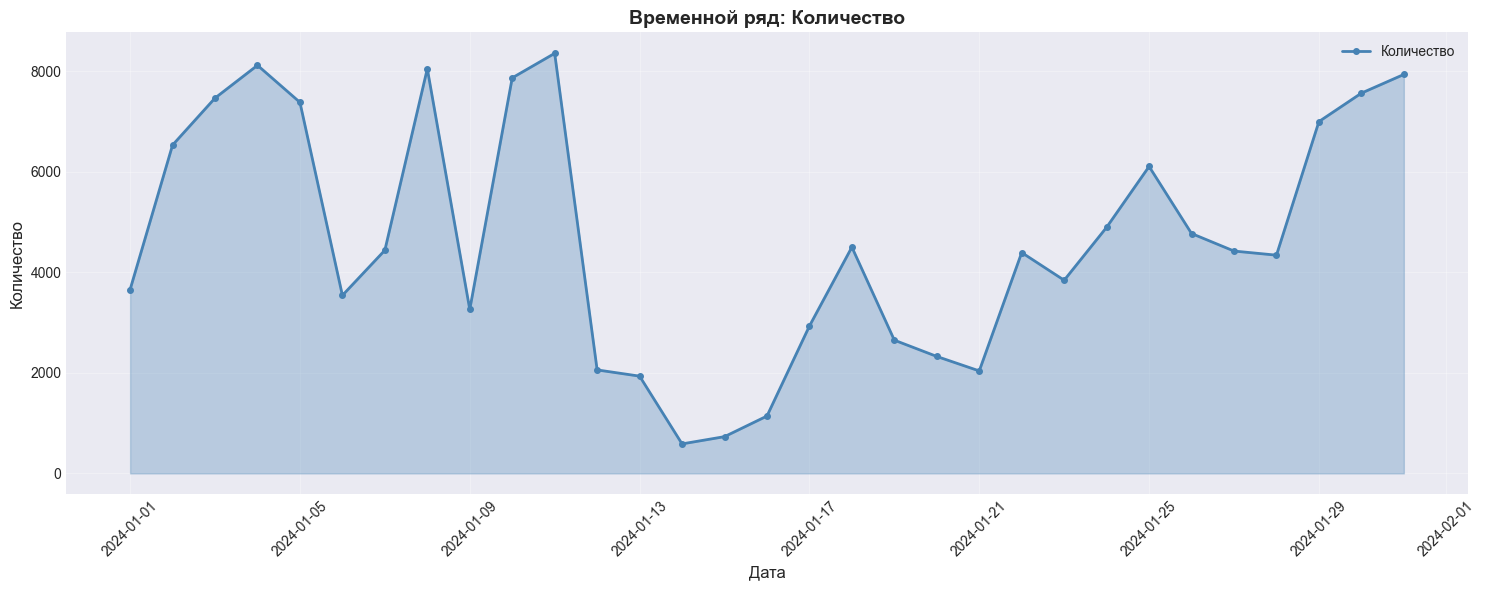

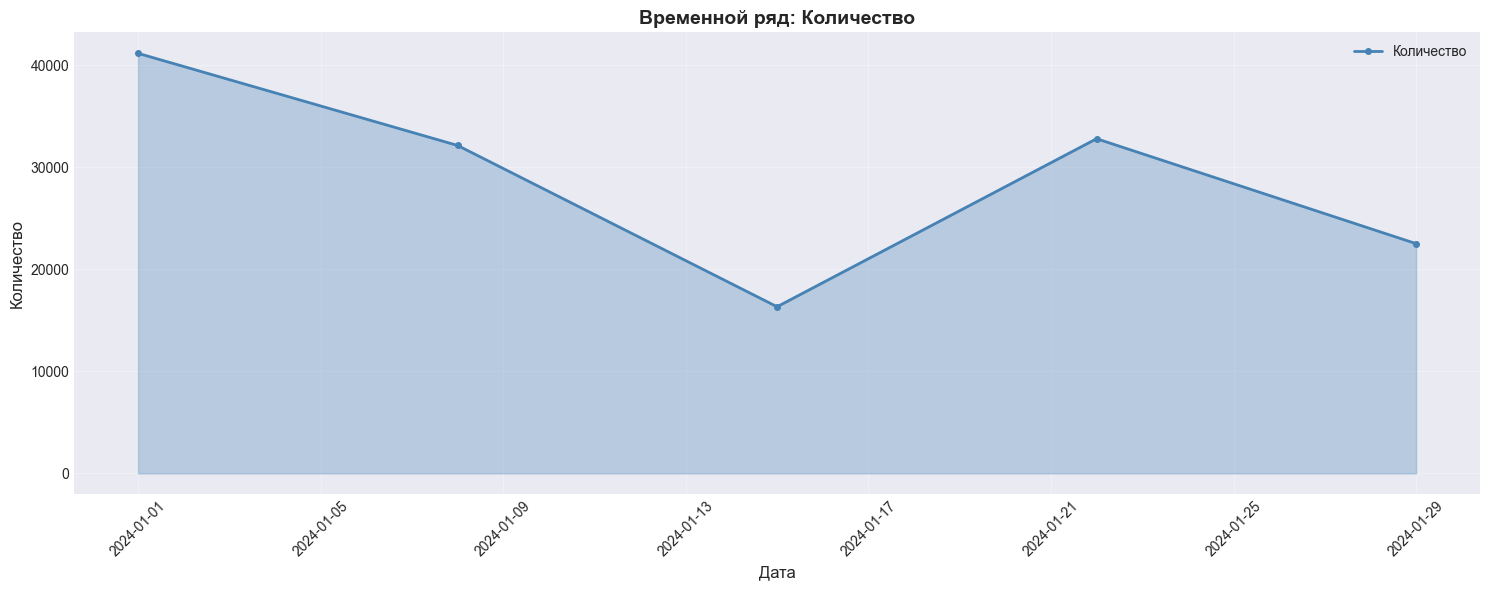

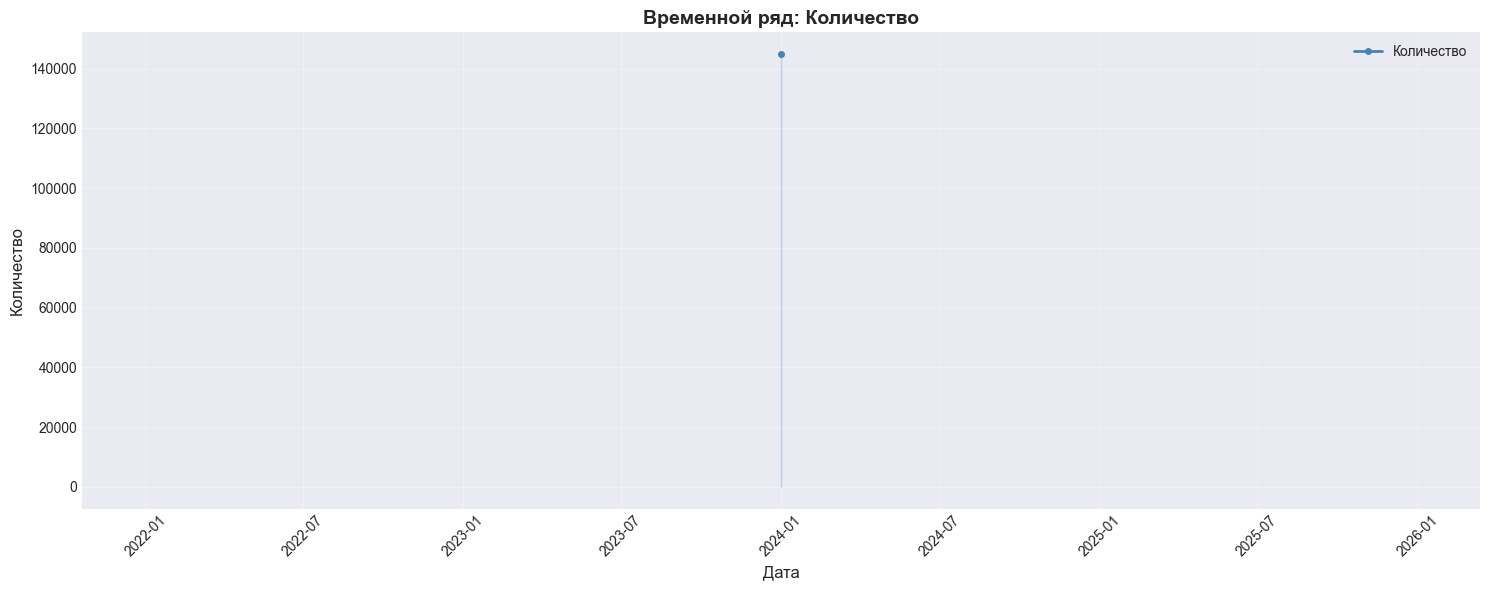

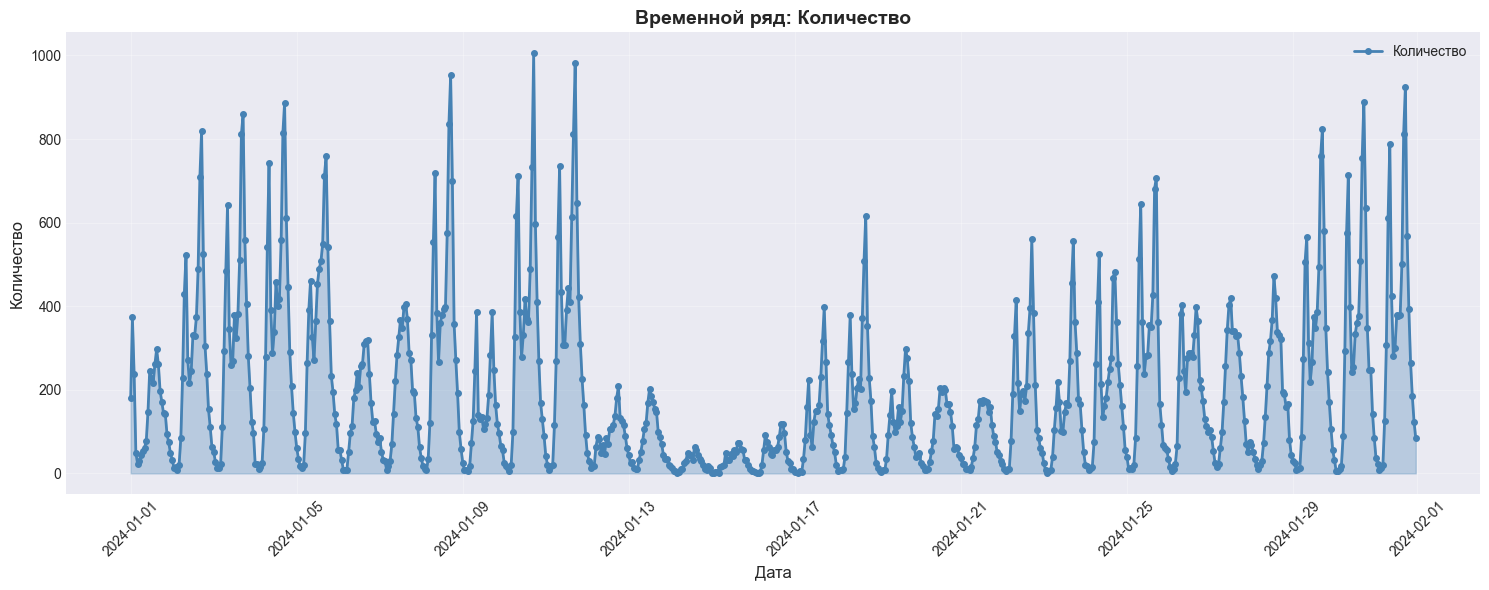

Начинаем визуальное исследование данных...

1. Распределения числовых переменных


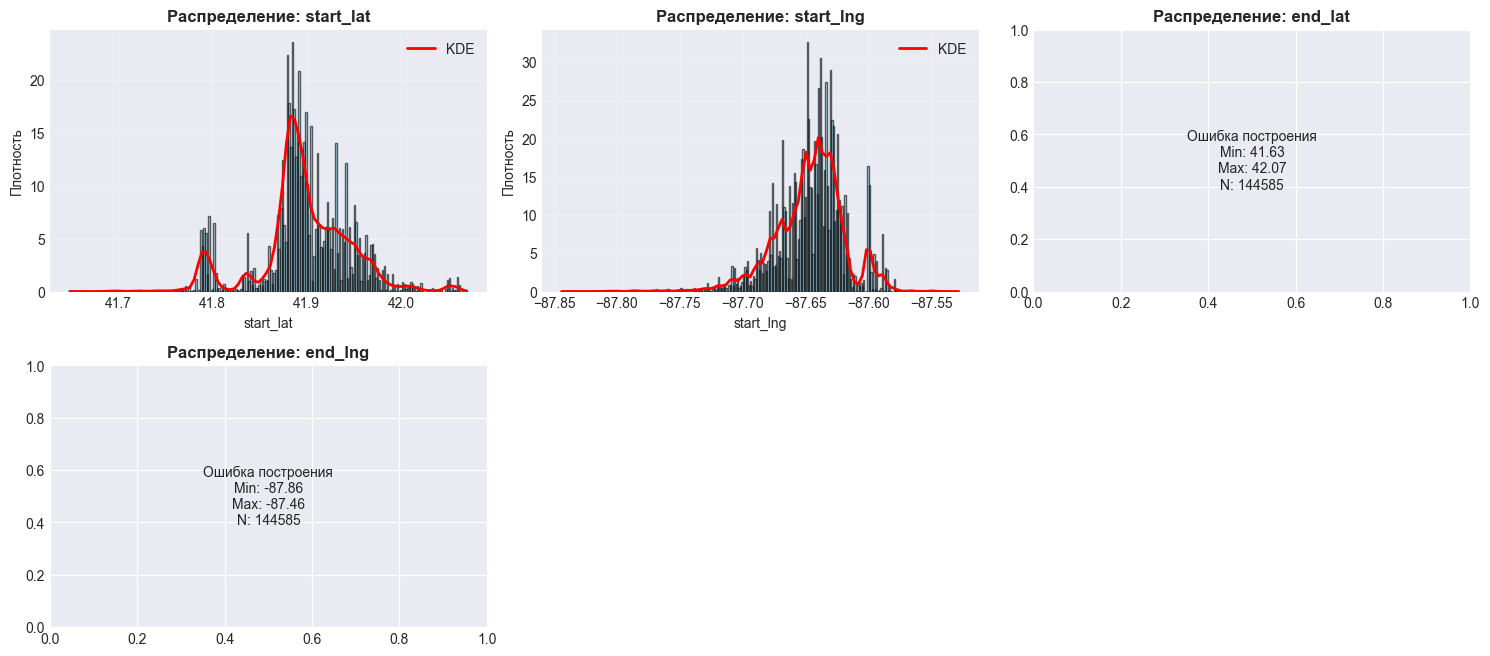


2. Boxplot'ы числовых переменных


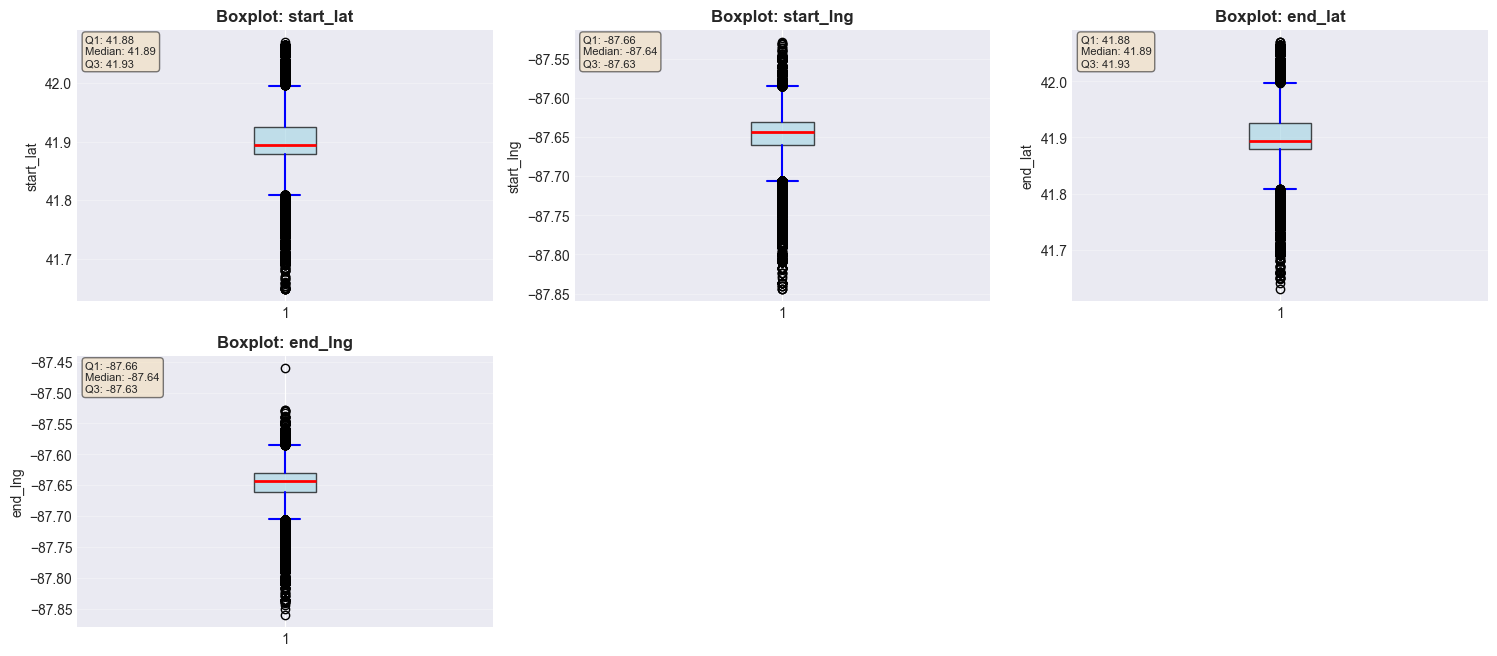


3. Матрица корреляций


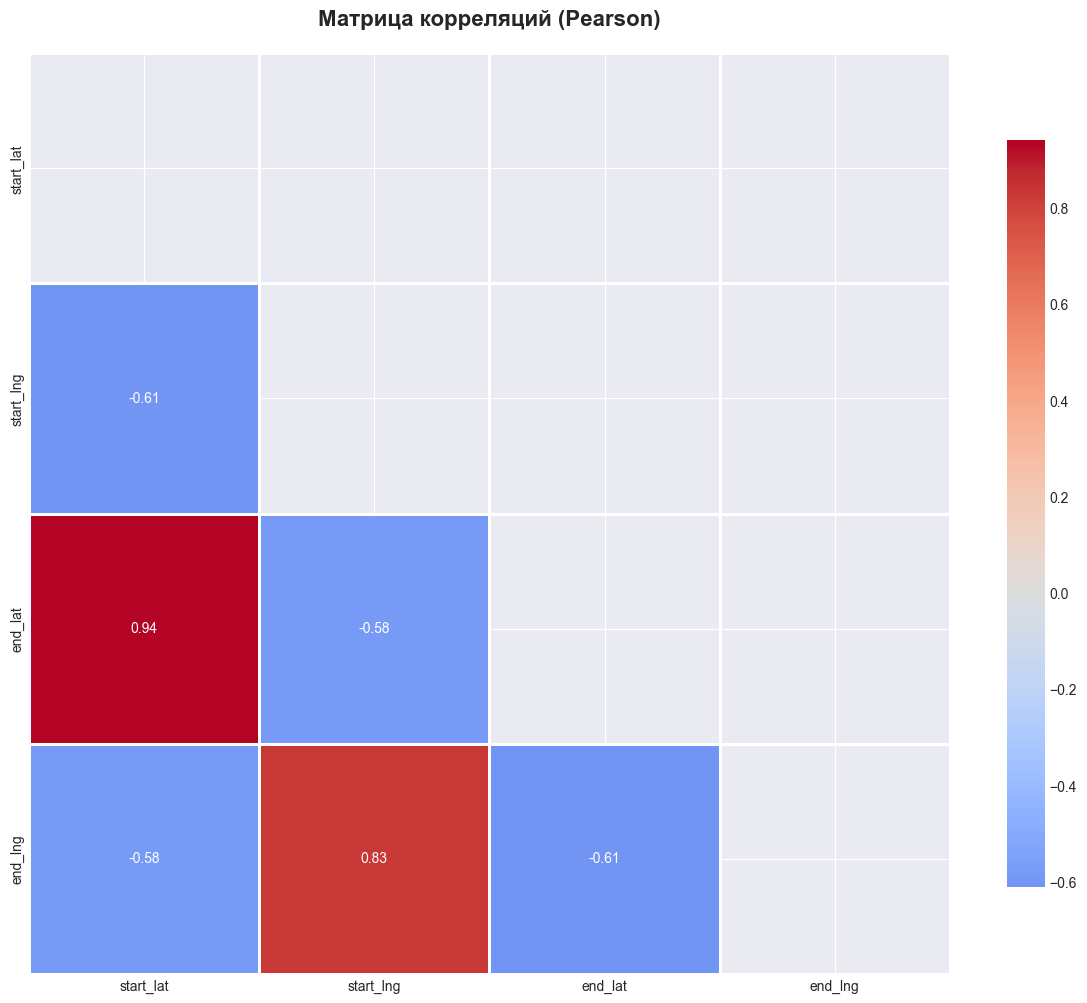


3.1. Парные графики для колонок: ['start_lat', 'start_lng', 'end_lat', 'end_lng']
Построение pairplot для 4 колонок...


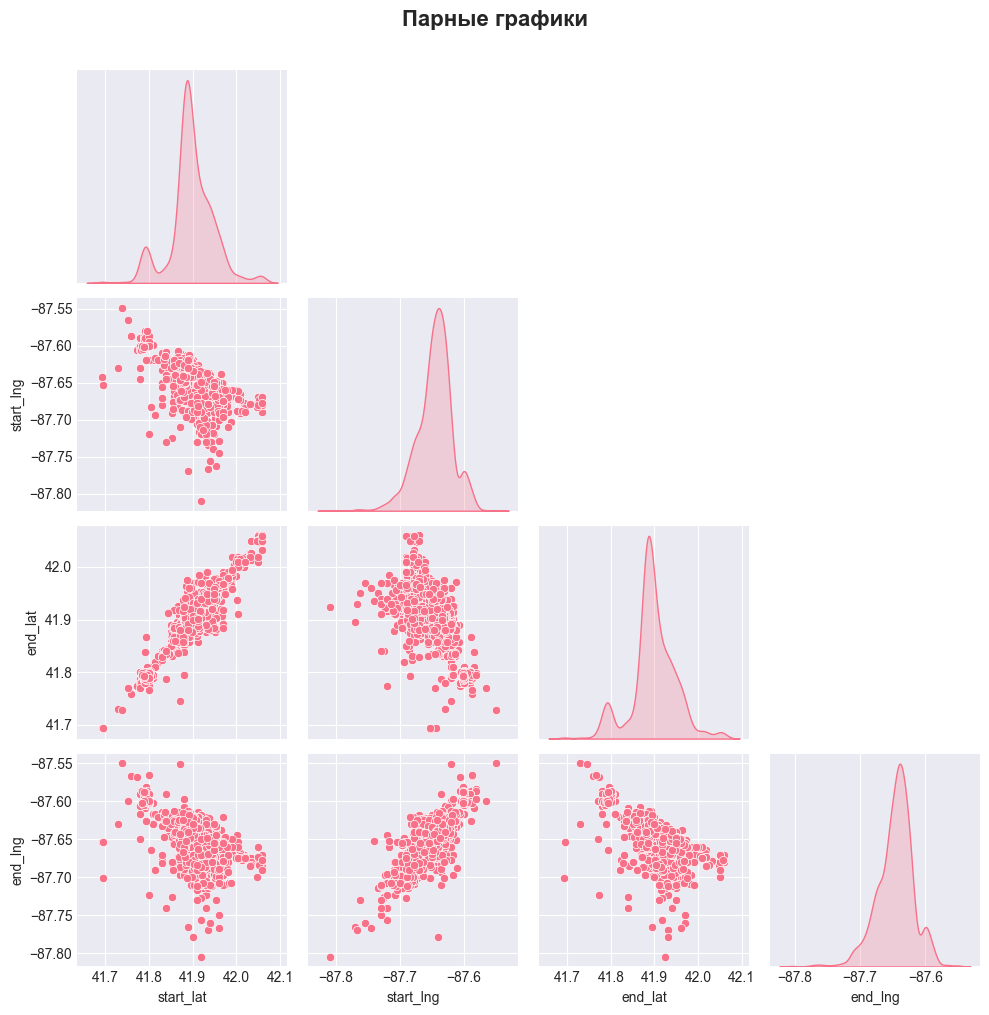


4. Категориальные переменные


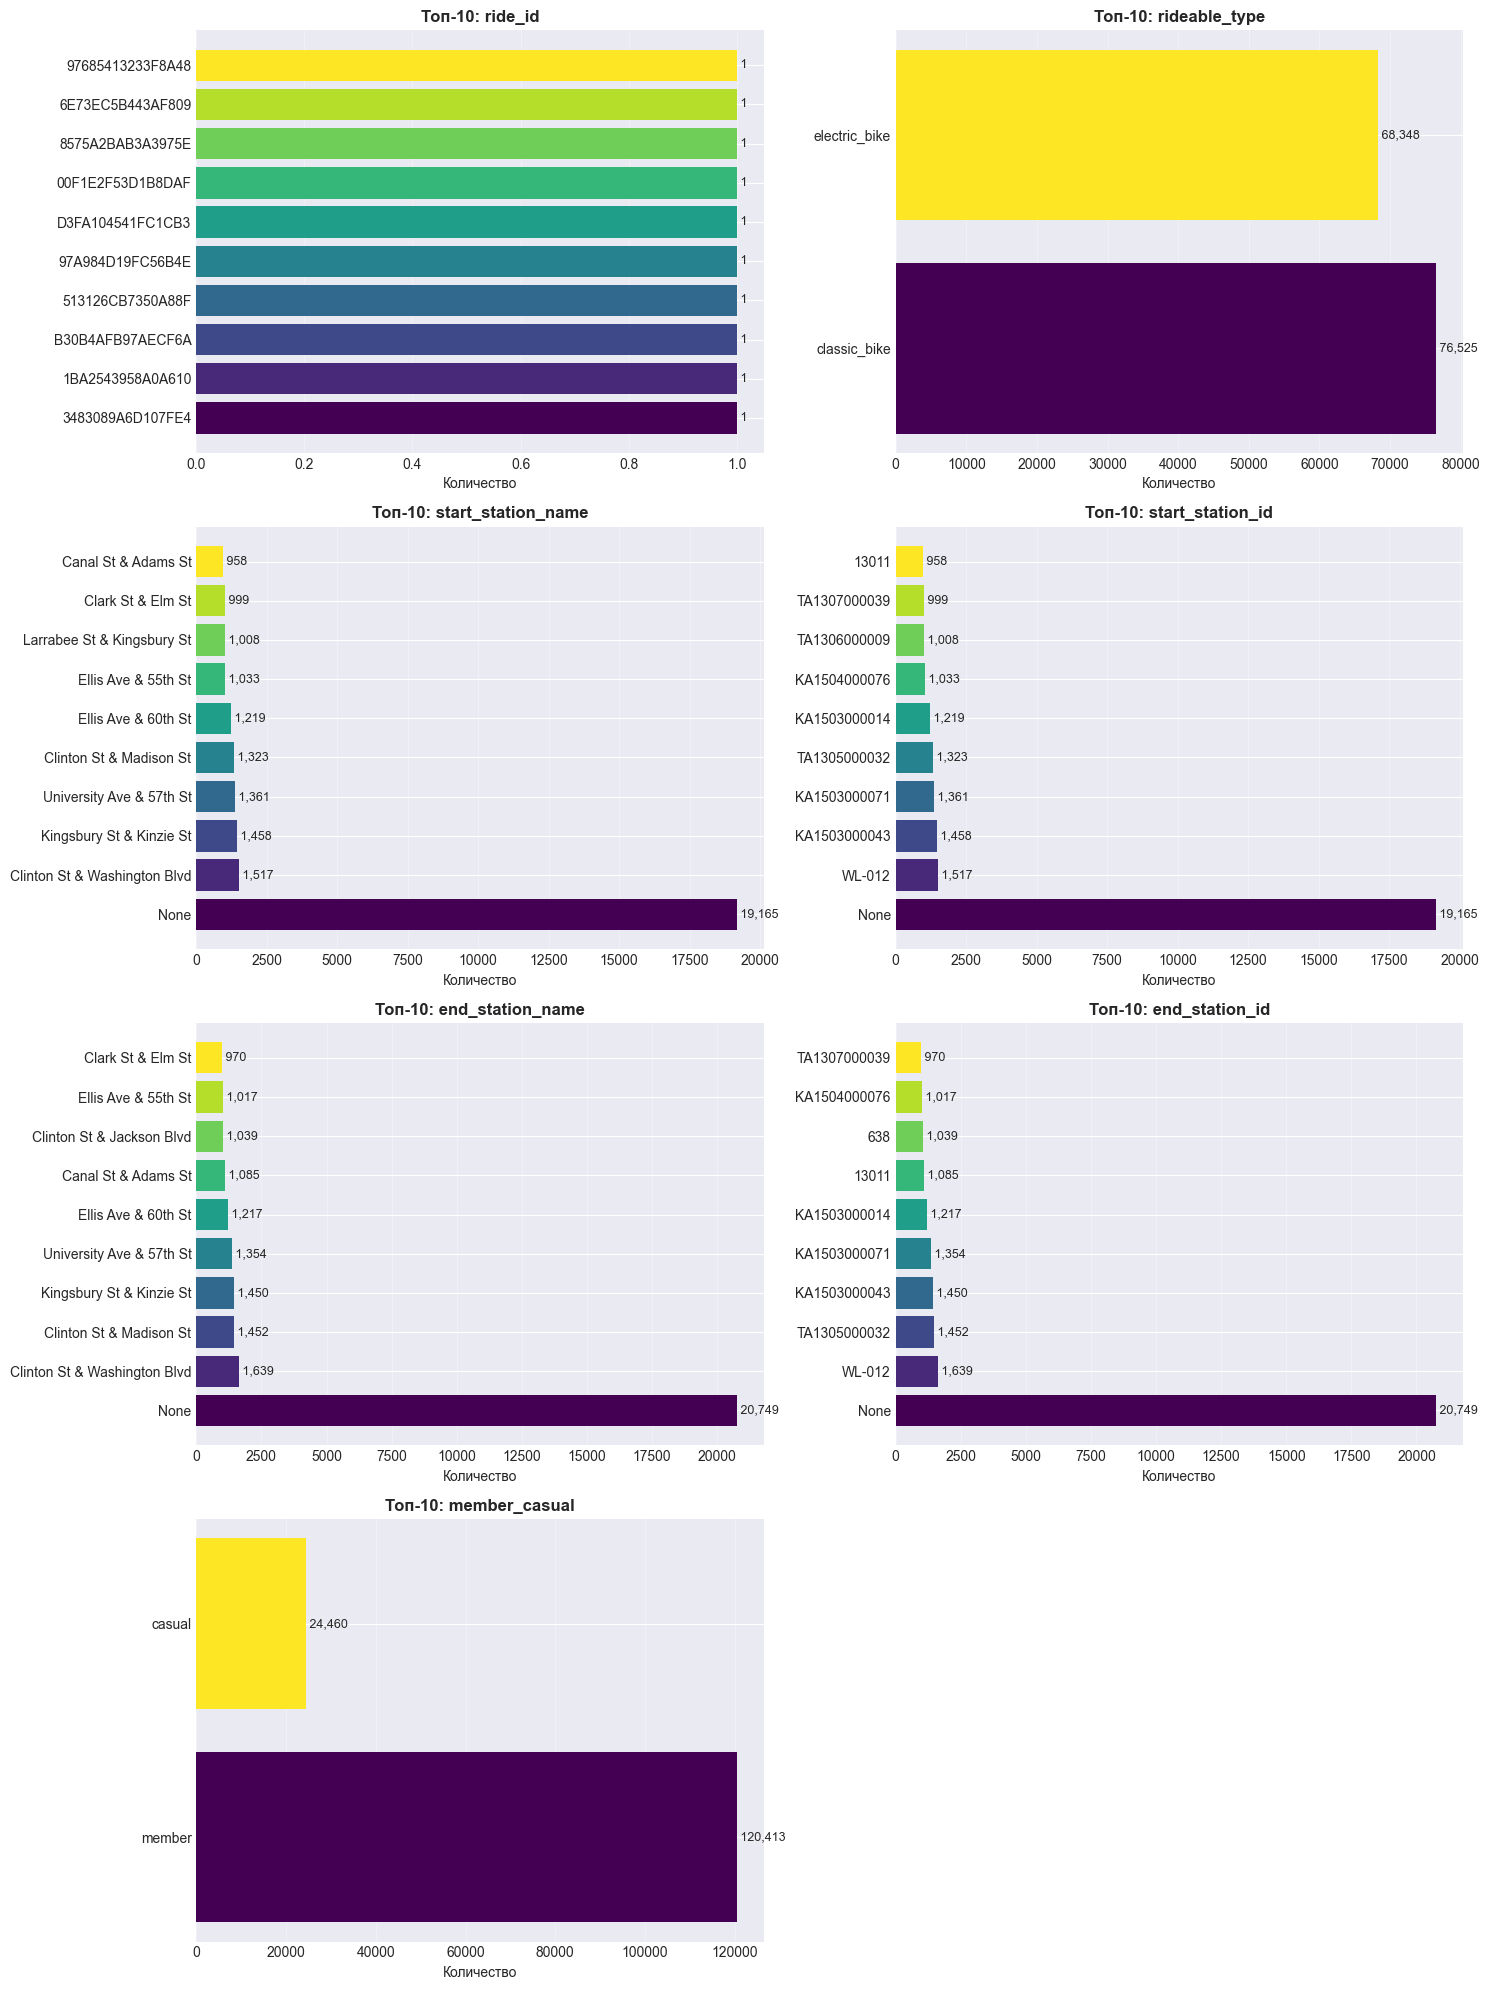


5. Карта пропусков


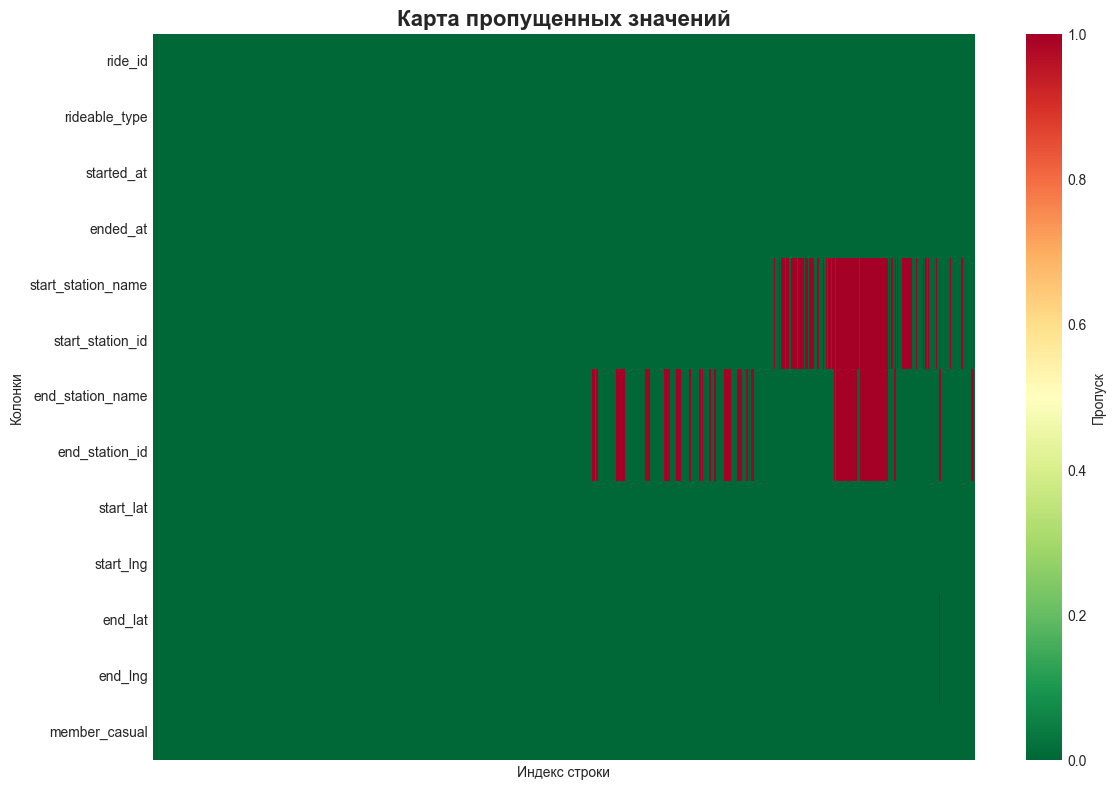


6. Временной ряд по started_at


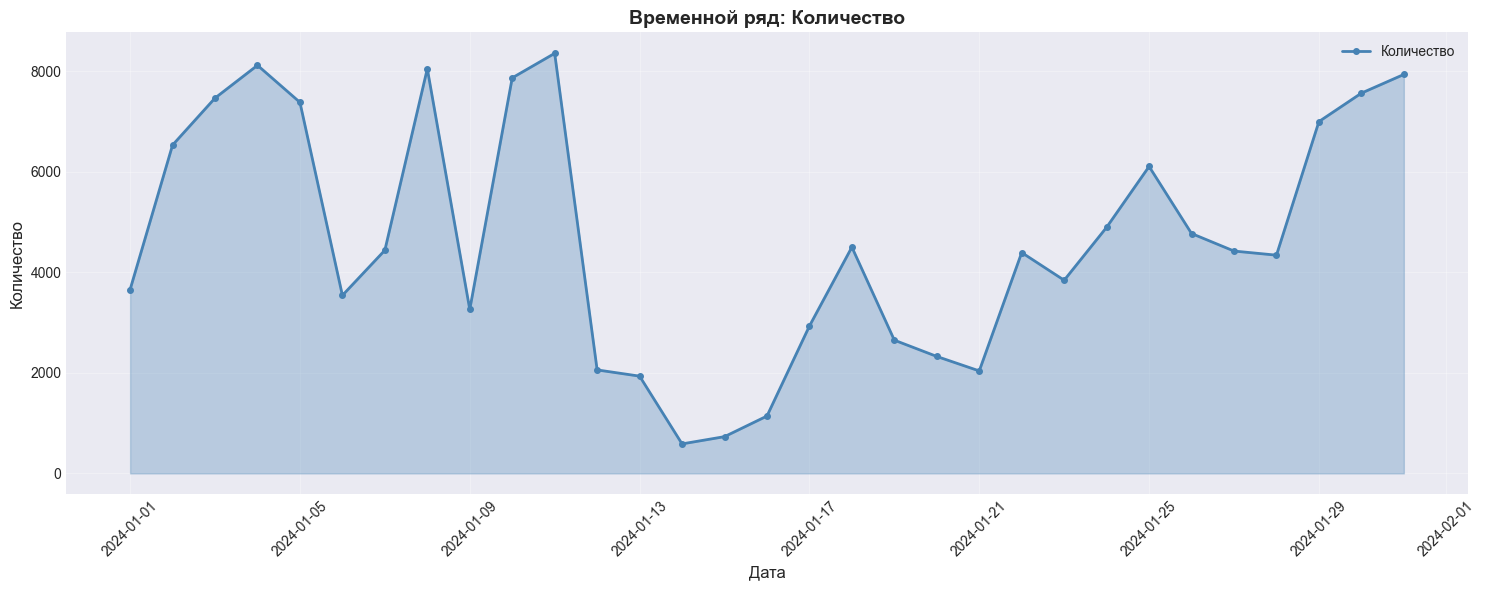


Визуальное исследование завершено!


In [8]:
from src.data.load_data import load_raw_data
from src.visualization import DataExplorer

trips = load_raw_data(year=2024, month=1)
explorer = DataExplorer(trips)

# Временные ряды (правильный формат)
explorer.plot_time_series('started_at', freq='1d')   # ✅ День
explorer.plot_time_series('started_at', freq='1w')   # ✅ Неделя
explorer.plot_time_series('started_at', freq='1mo')  # ✅ Месяц
explorer.plot_time_series('started_at', freq='1h')   # ✅ Час

# Все графики сразу
explorer.explore_all()


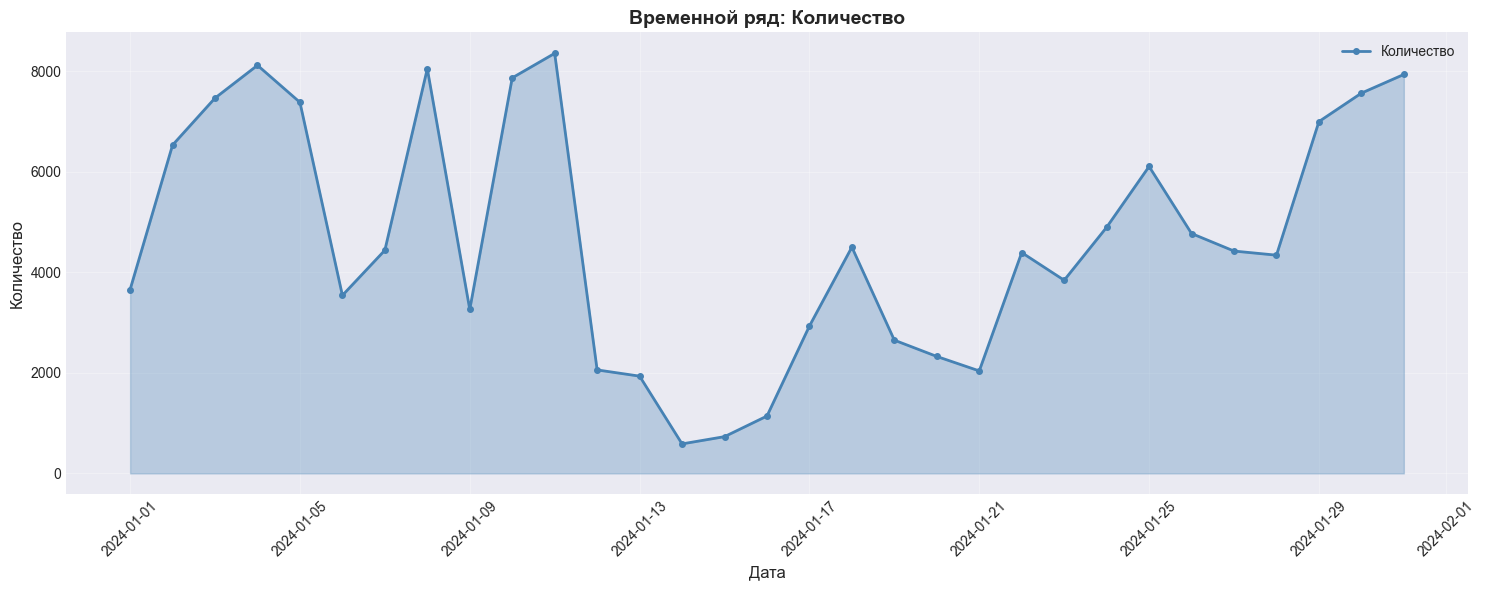

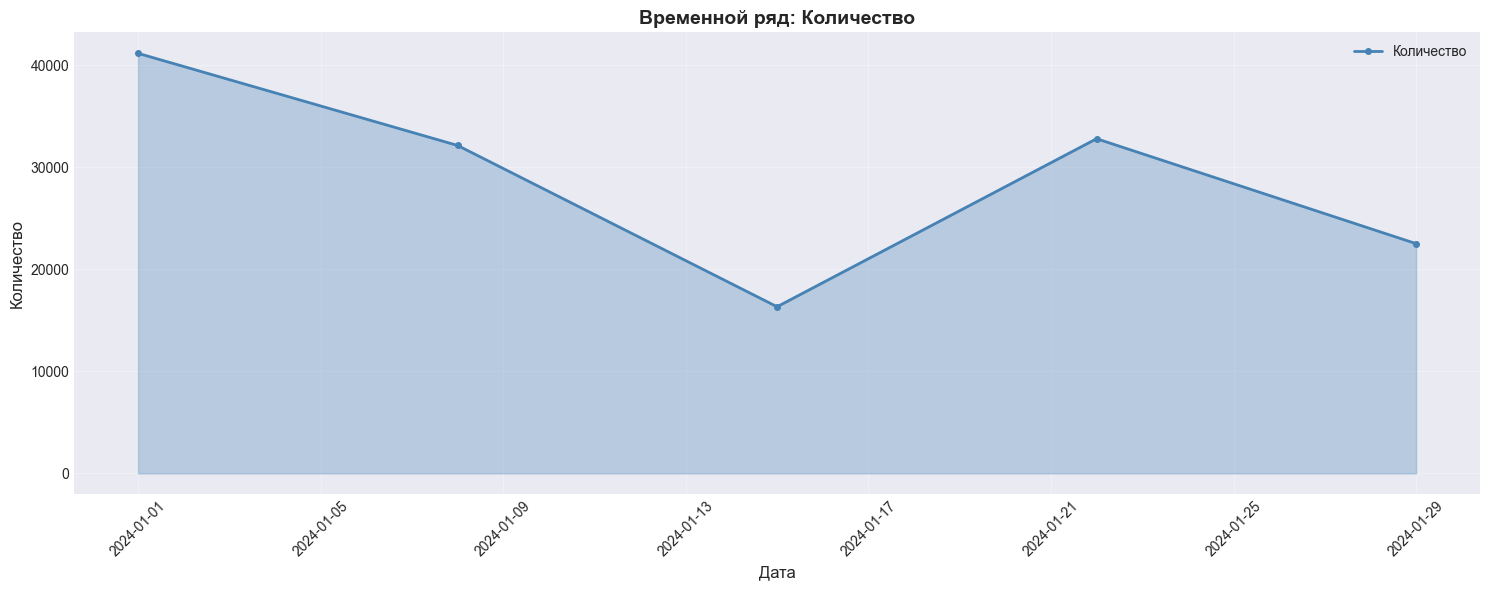

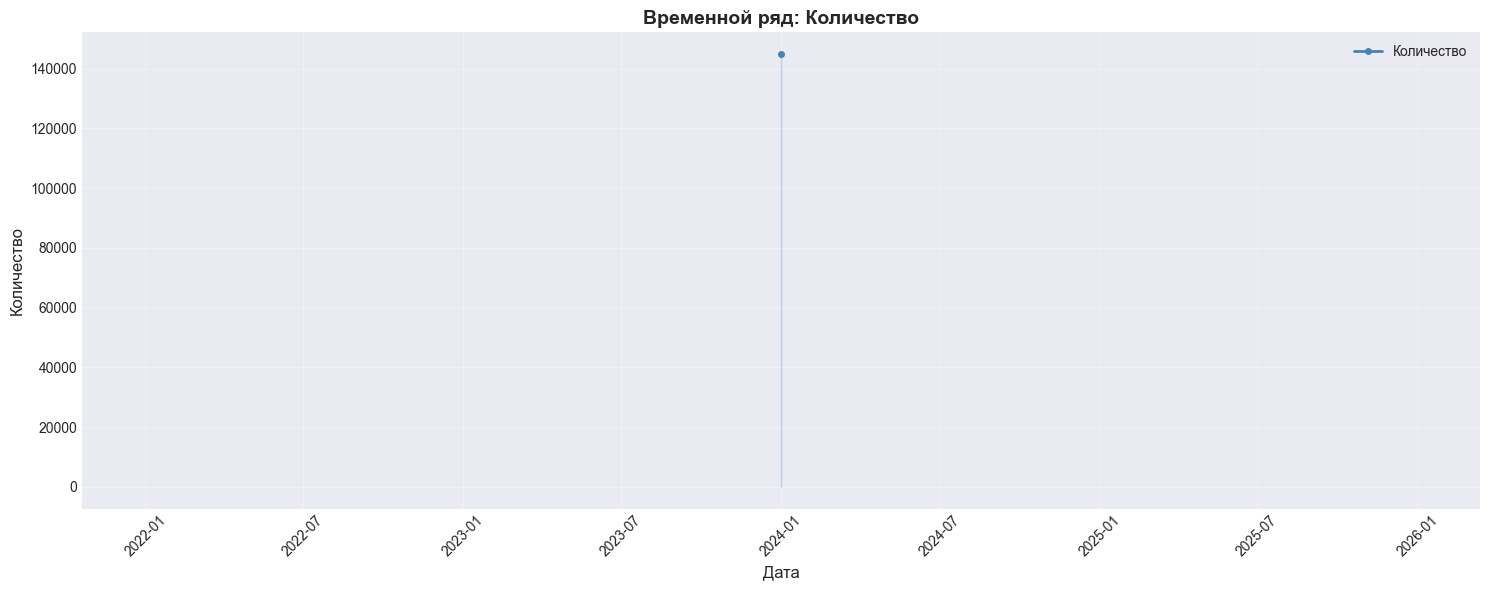

In [9]:
from src.data.load_data import load_raw_data
from src.visualization import DataExplorer

trips = load_raw_data(year=2024, month=1)
explorer = DataExplorer(trips)

# Правильный формат частоты
explorer.plot_time_series('started_at', freq='1d')   # ✅ День
explorer.plot_time_series('started_at', freq='1w')   # ✅ Неделя
explorer.plot_time_series('started_at', freq='1mo')  # ✅ Месяц


In [10]:

from pathlib import Path
import sys

PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

Начинаем визуальное исследование данных...

1. Распределения числовых переменных


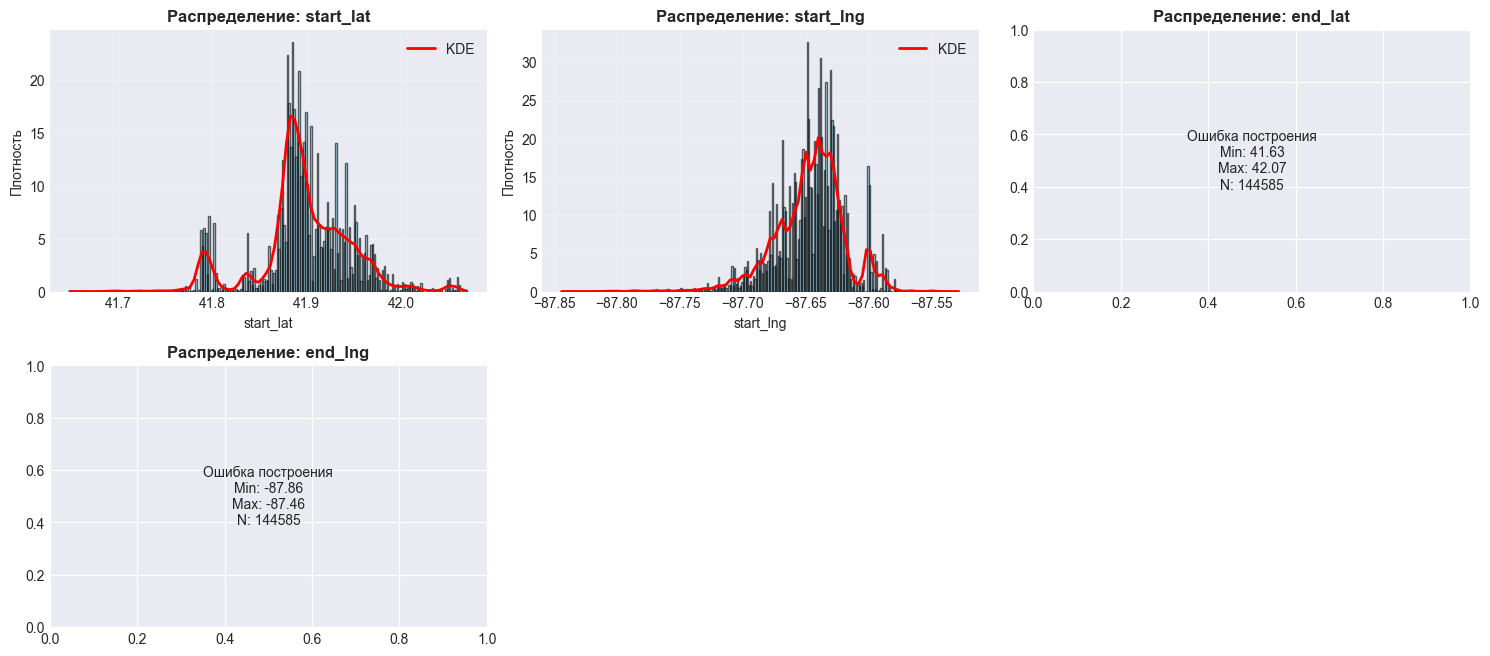


2. Boxplot'ы числовых переменных


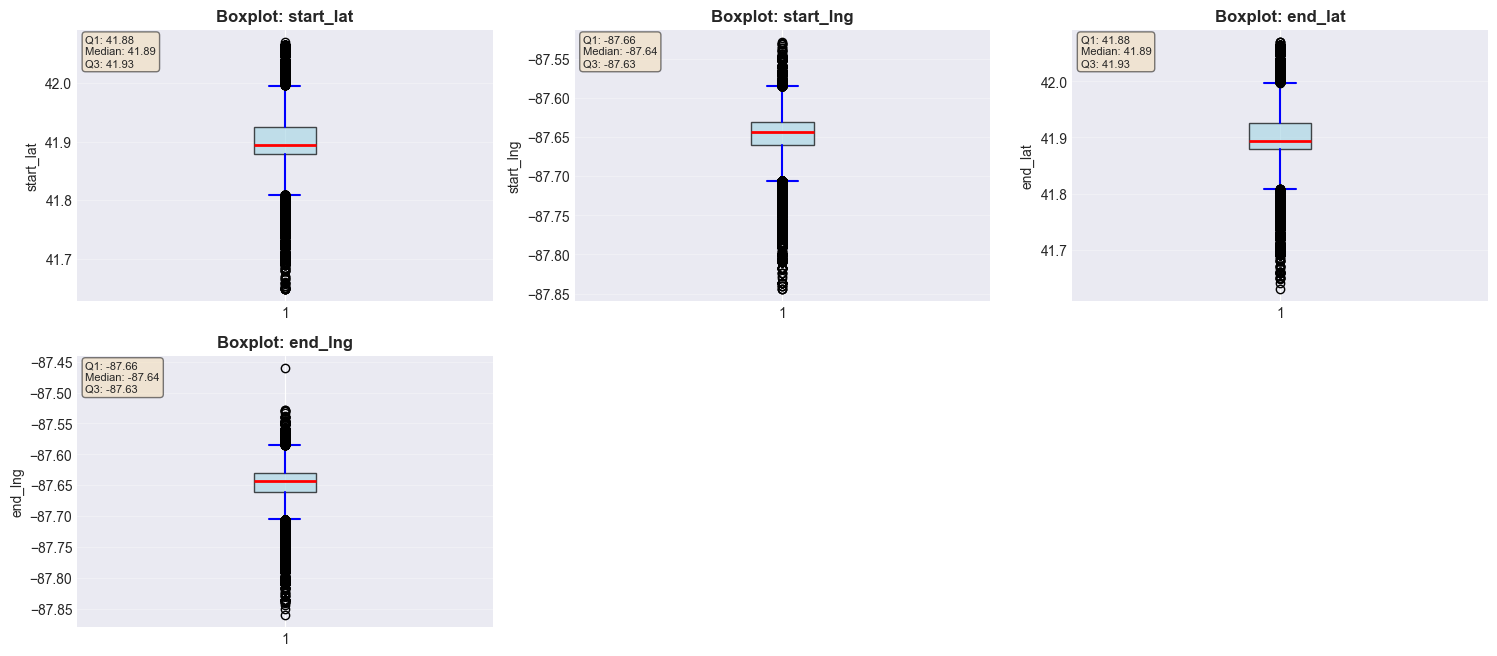


3. Матрица корреляций


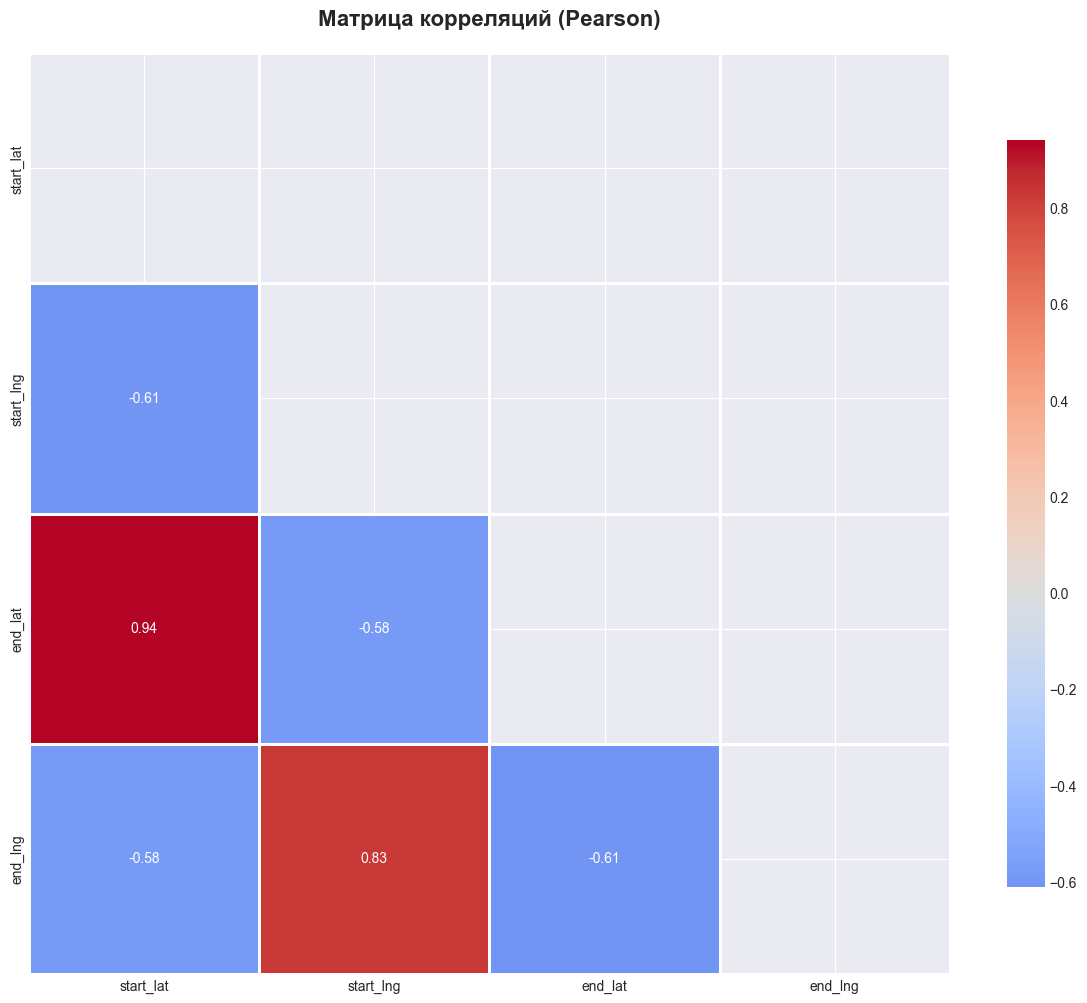


3.1. Парные графики для колонок: ['start_lat', 'start_lng', 'end_lat', 'end_lng']
Построение pairplot для 4 колонок...


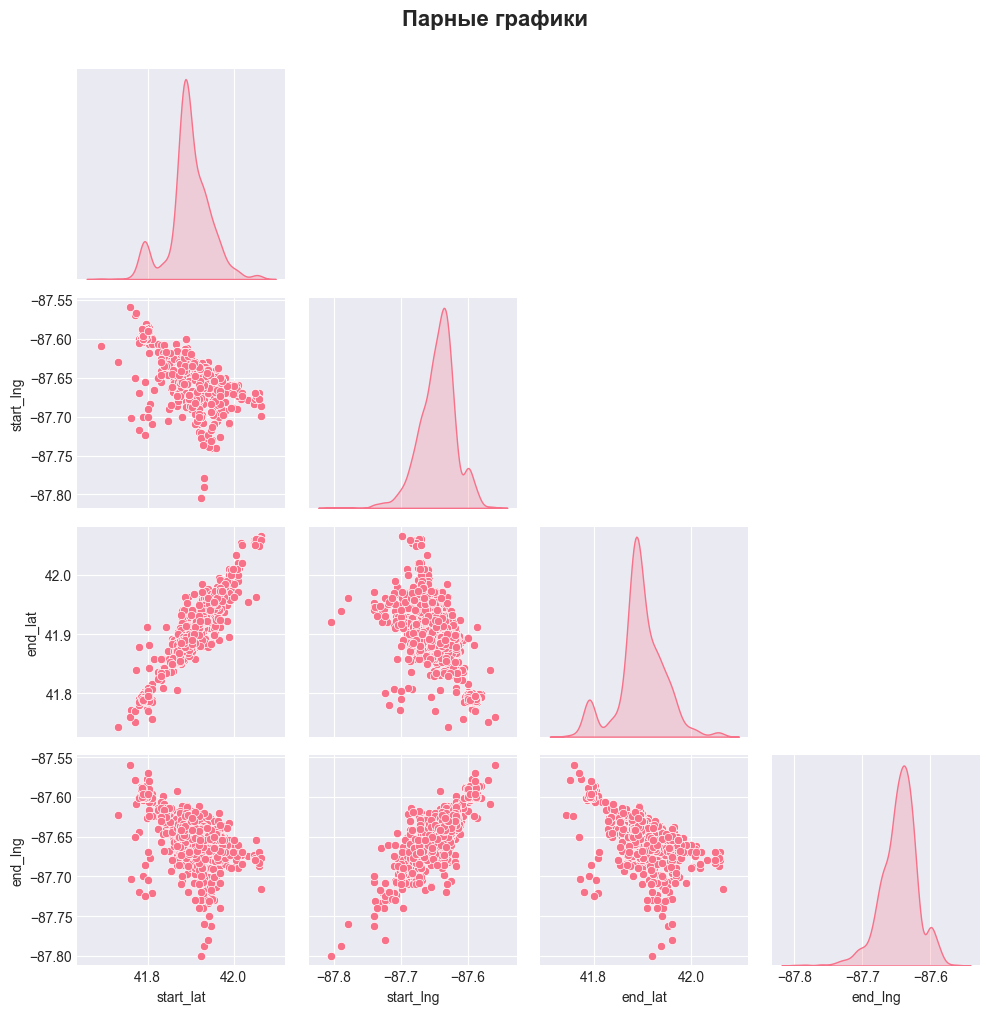


4. Категориальные переменные


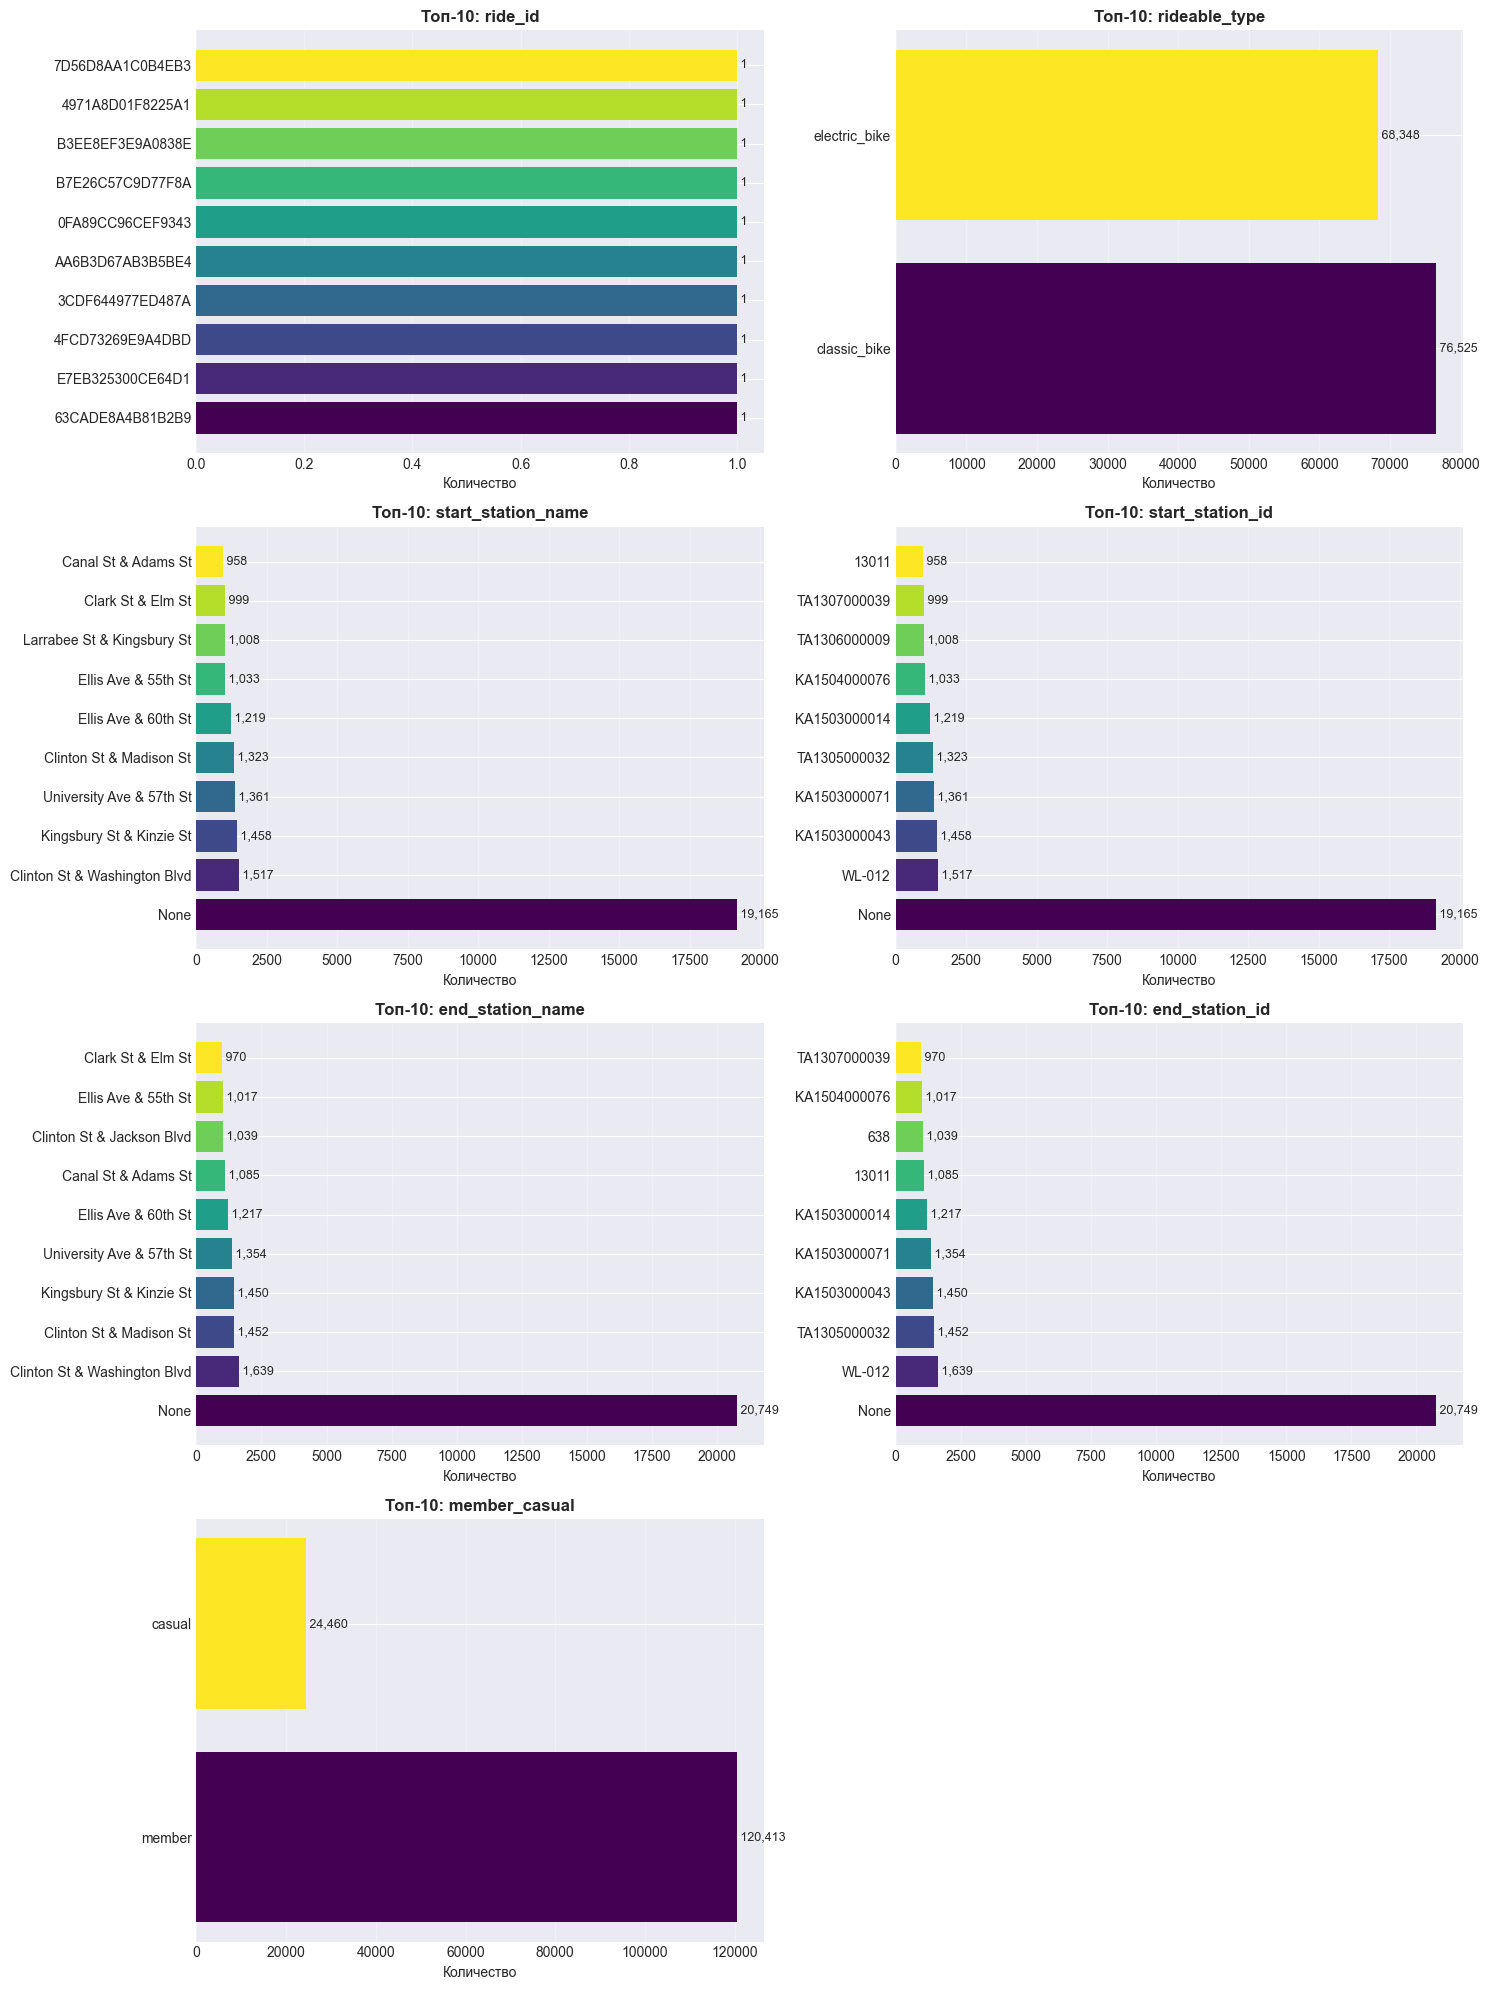


5. Карта пропусков


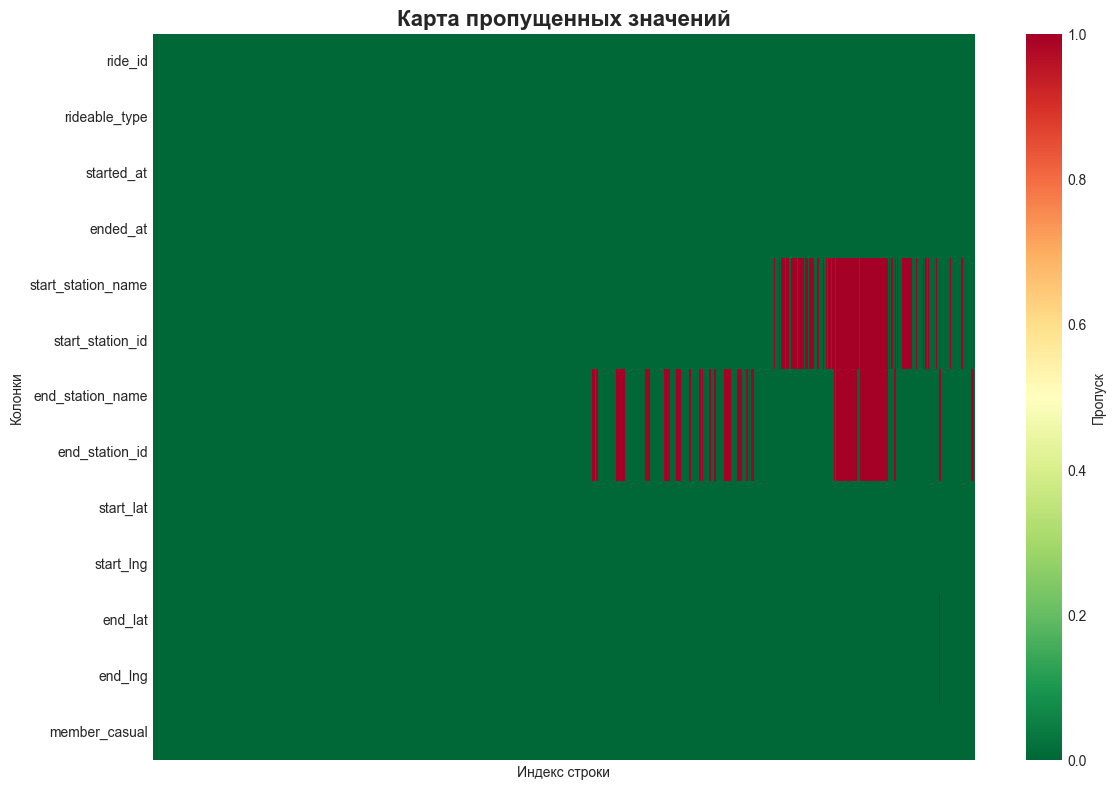


6. Временной ряд по started_at


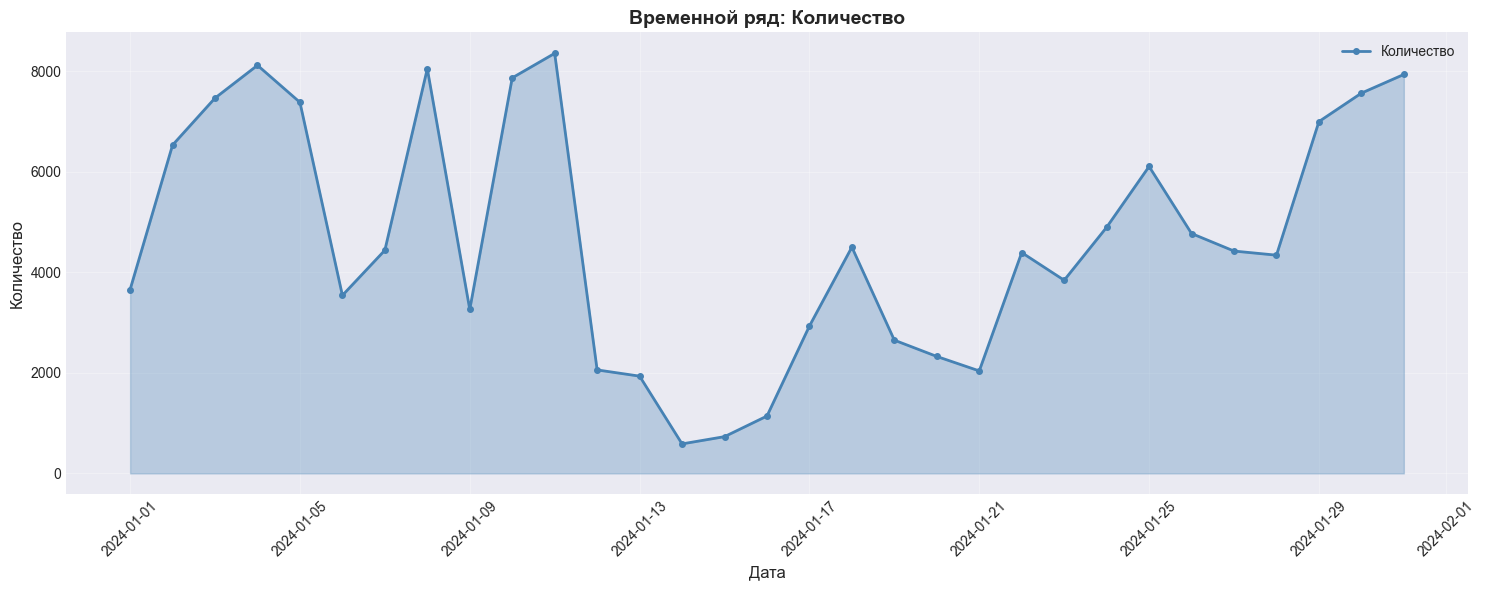


Визуальное исследование завершено!
Начинаем визуальное исследование данных...

1. Распределения числовых переменных


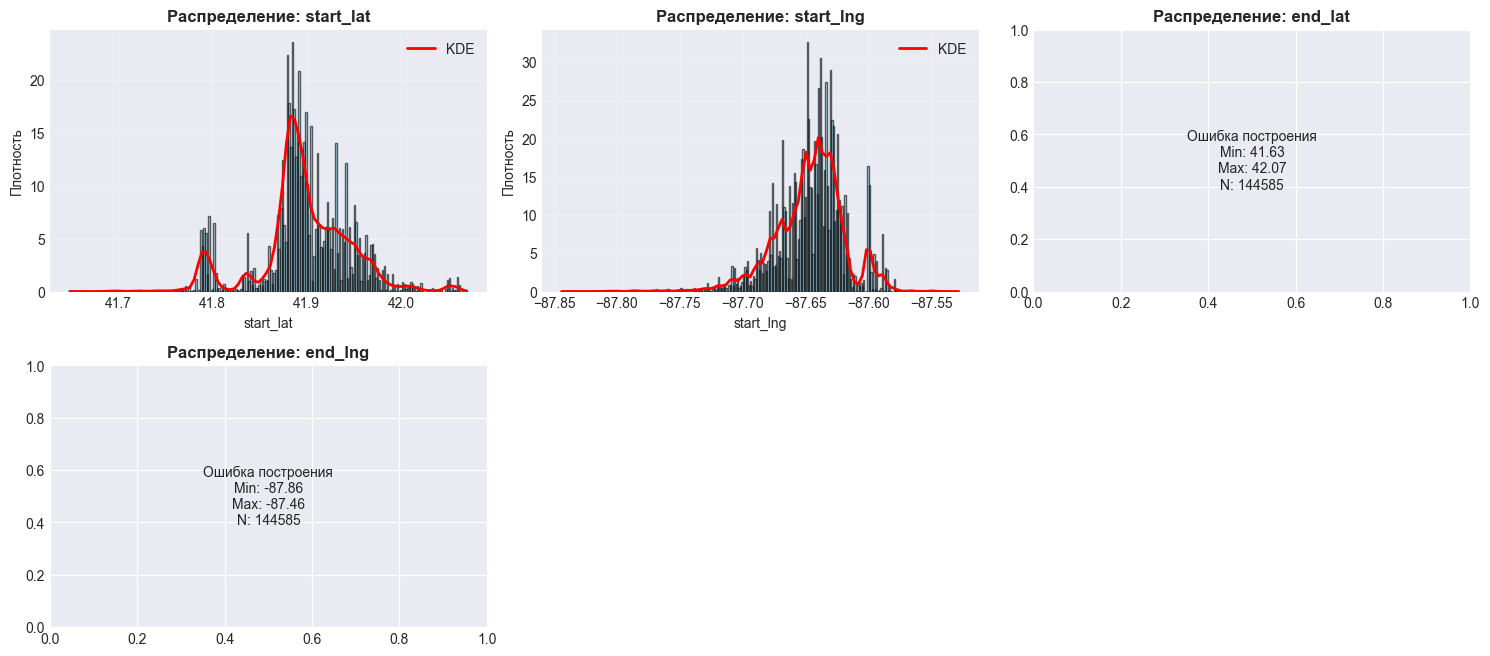


2. Boxplot'ы числовых переменных


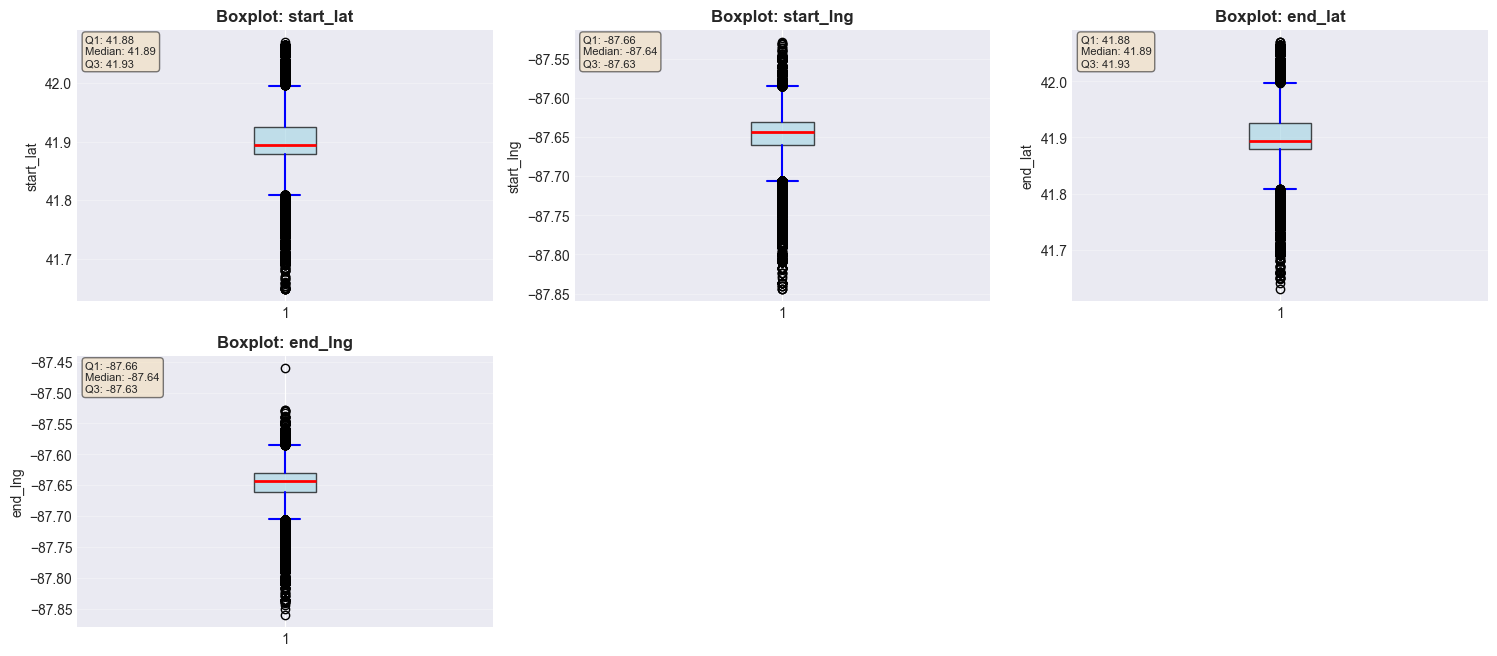


3. Матрица корреляций


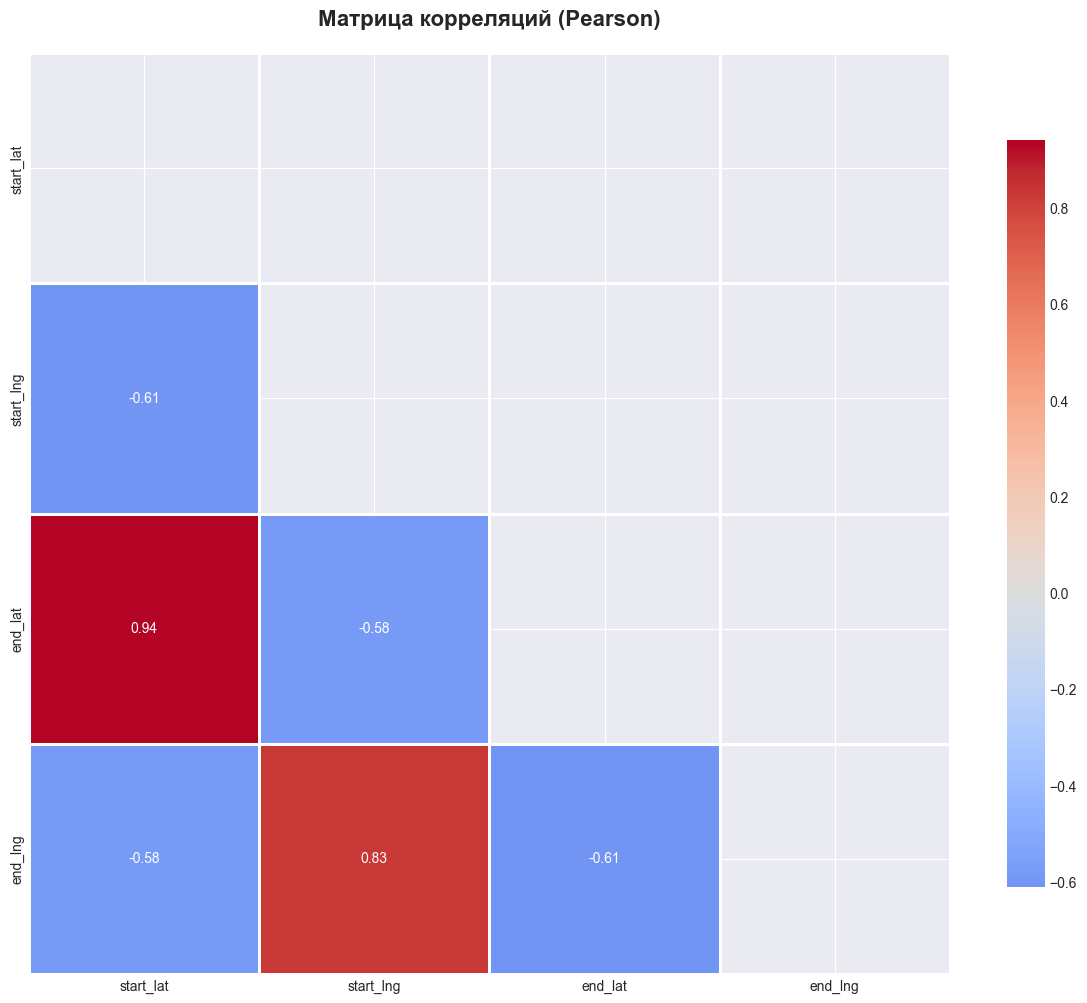


4. Категориальные переменные


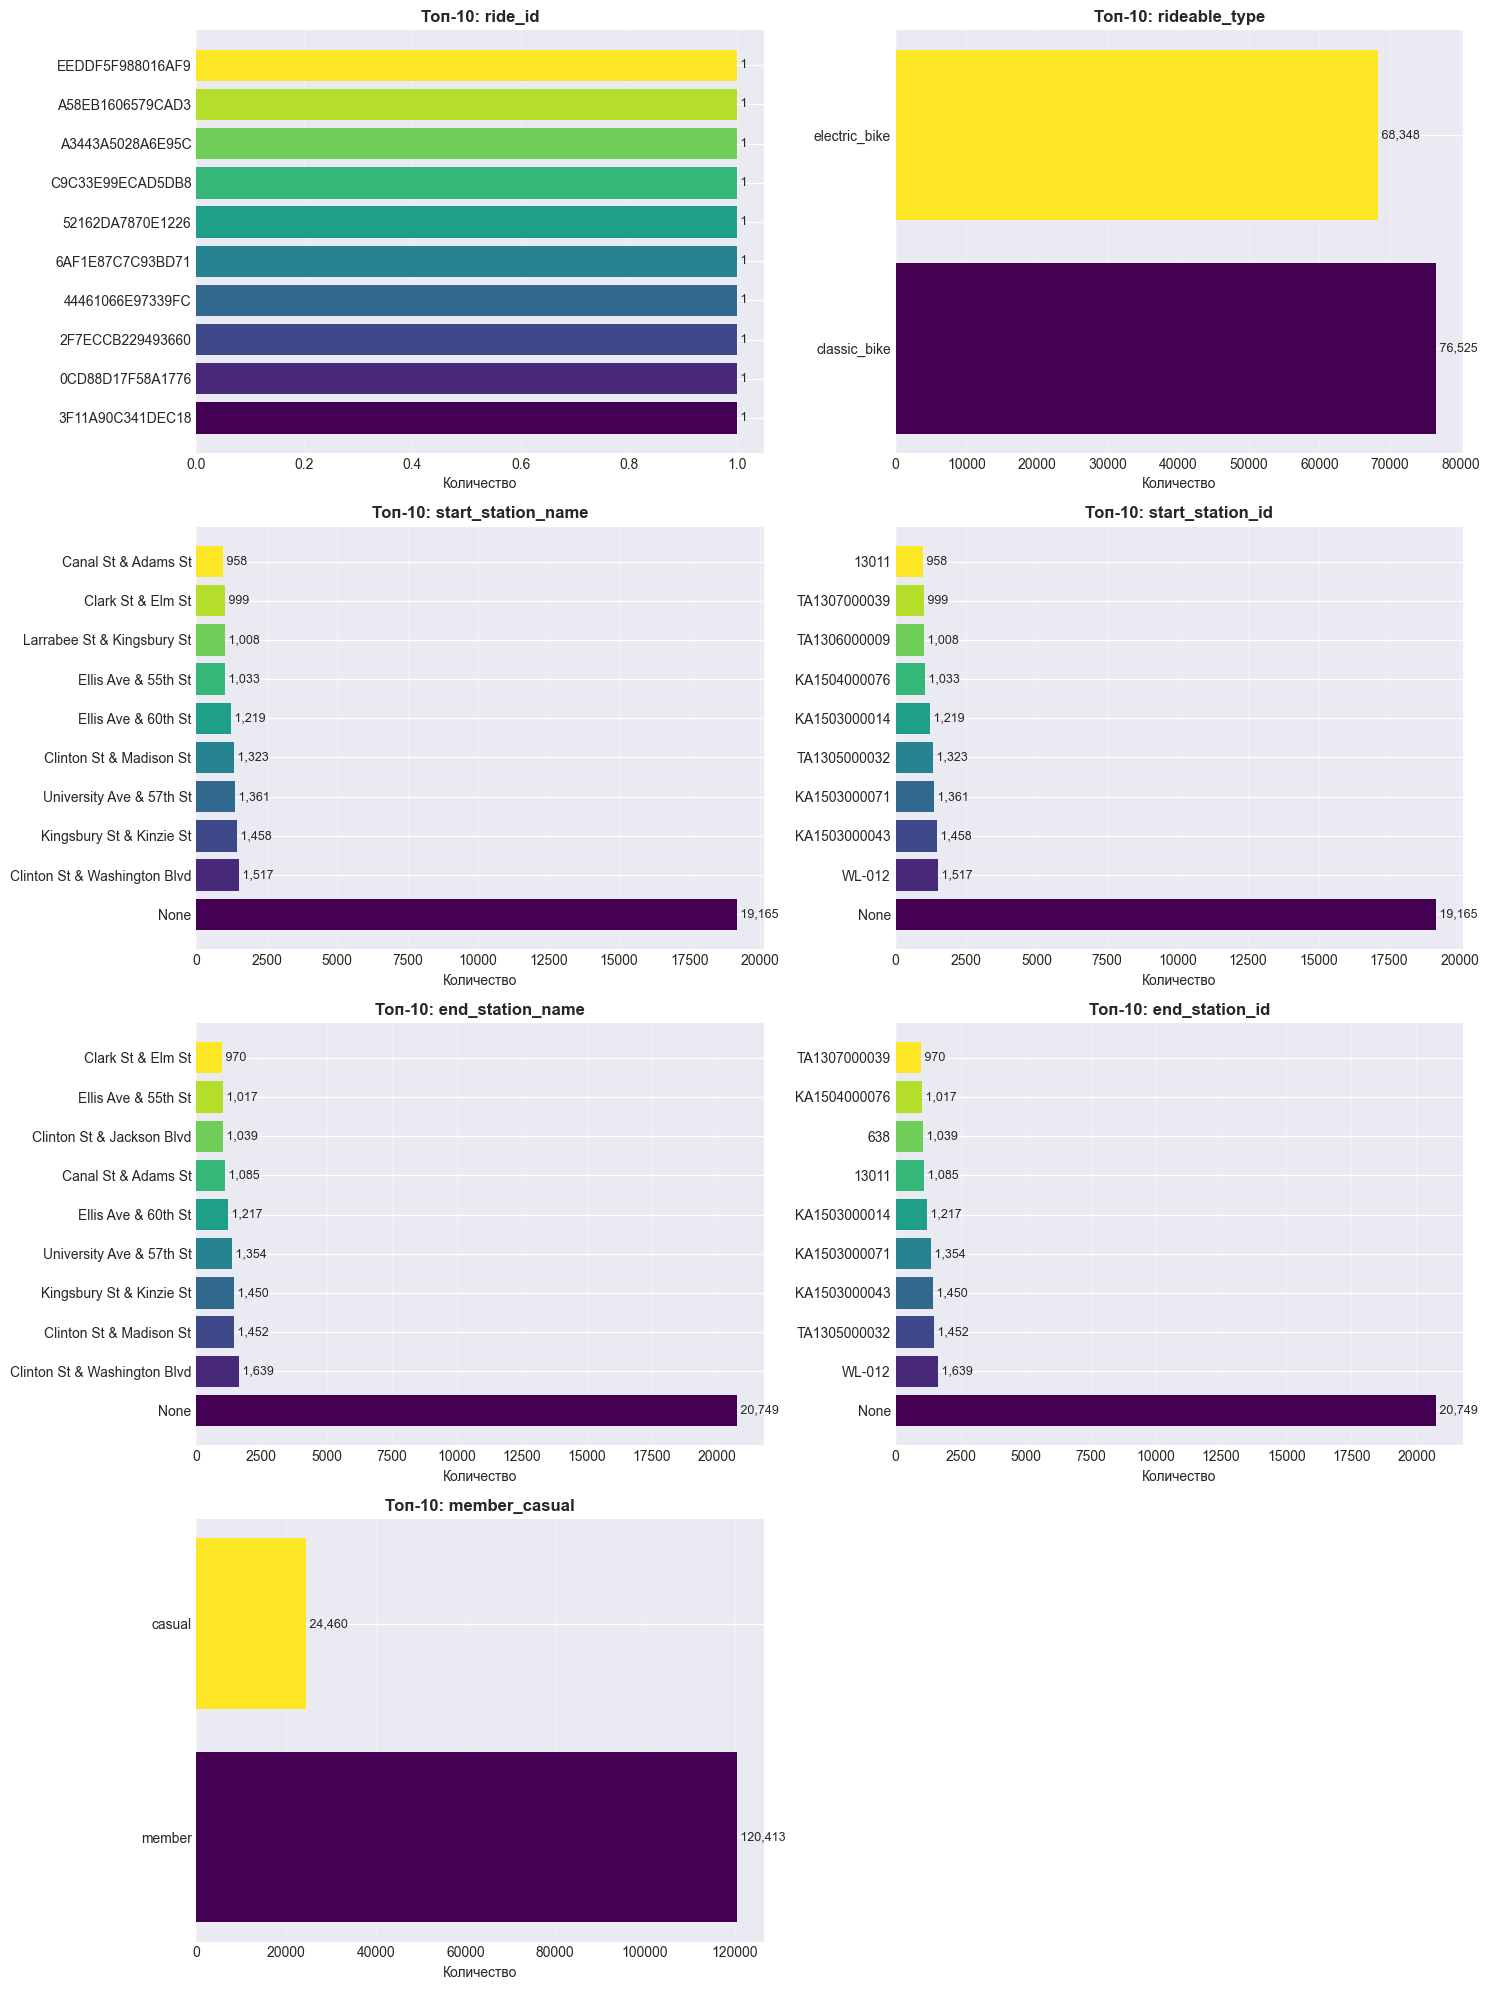


5. Карта пропусков


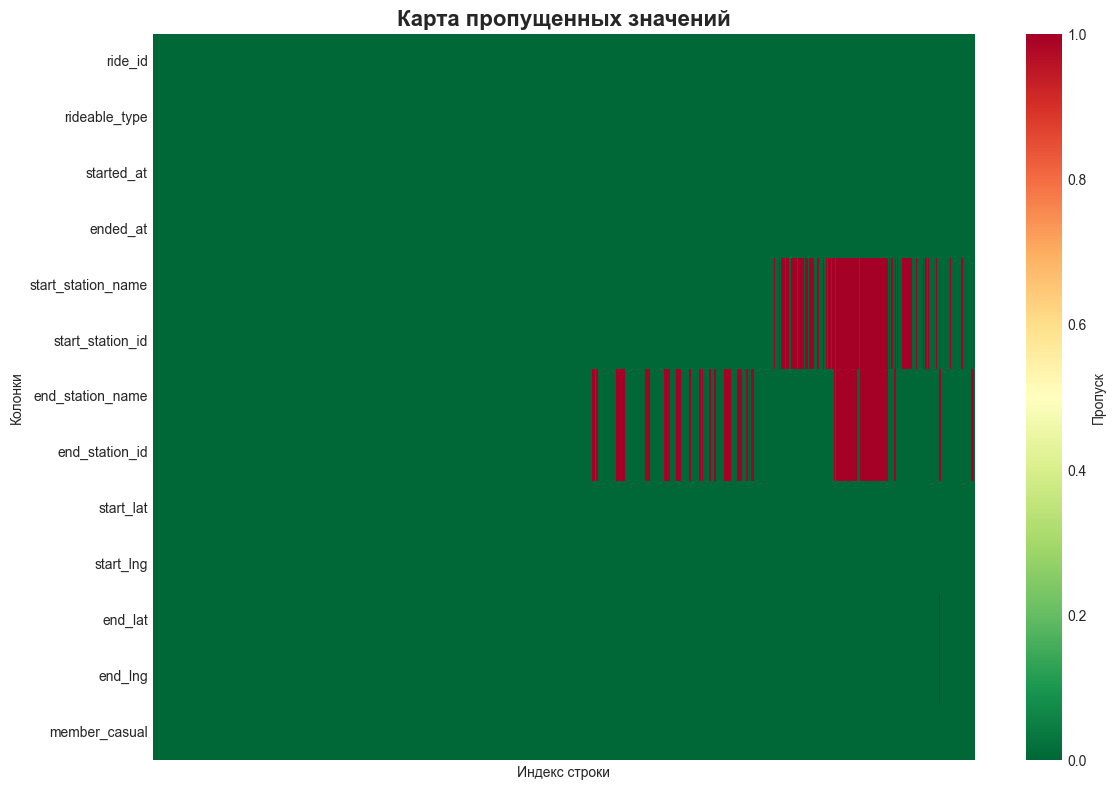


Визуальное исследование завершено!


In [11]:
import polars as pl
from src.data.load_data import load_raw_data
from src.visualization import explore_data

# Загрузить данные (Polars DataFrame)
trips: pl.DataFrame = load_raw_data(year=2024, month=1)

# Полное визуальное исследование
explore_data(trips)

# Быстрый режим (без тяжёлых графиков вроде pairplot)
explore_data(trips, quick=True)

In [12]:
import polars as pl
from src.data.load_data import load_raw_data

trips = load_raw_data(year=2024, month=1)
print("Числовые колонки:")
print([col for col, dtype in trips.schema.items() 
       if dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                    pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                    pl.Float32, pl.Float64]])

Числовые колонки:
['start_lat', 'start_lng', 'end_lat', 'end_lng']


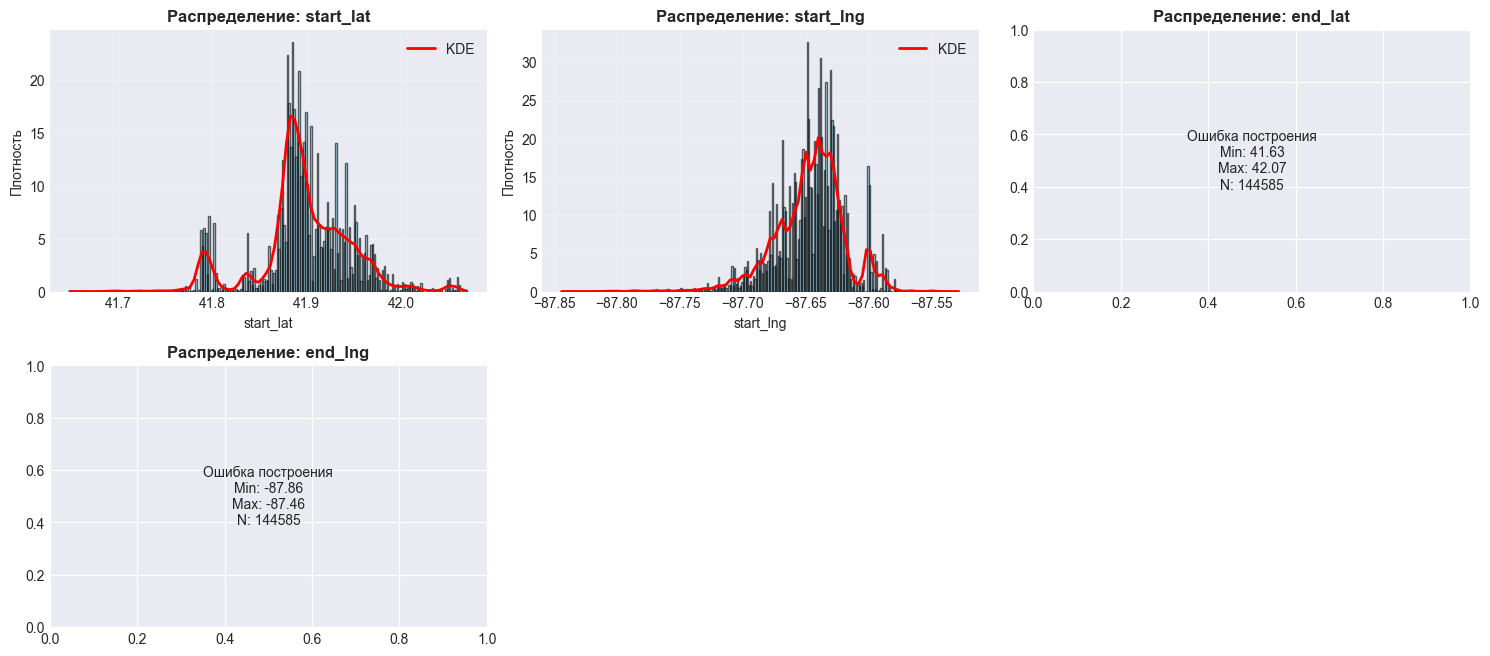

ColumnNotFoundError: "trip_duration" not found

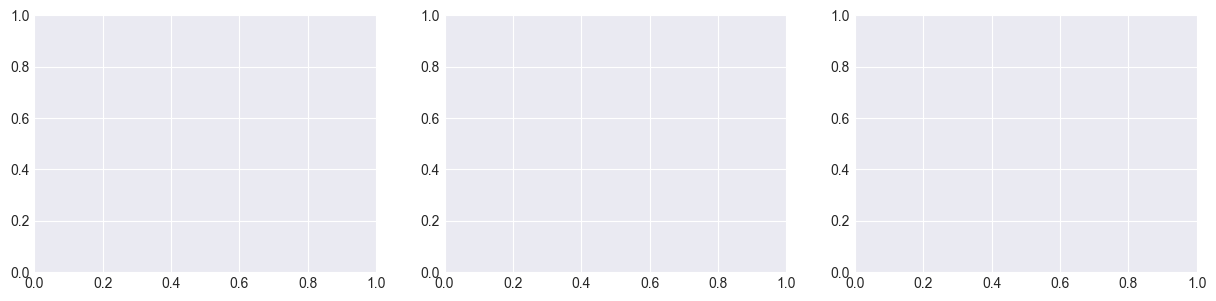

In [13]:
from src.visualization import plot_distributions

plot_distributions(trips, plots_per_row=3)

# Для признаков с длинными хвостами (например, длительность поездки)
plot_distributions(trips, cols=["trip_duration"], log_scale=True)

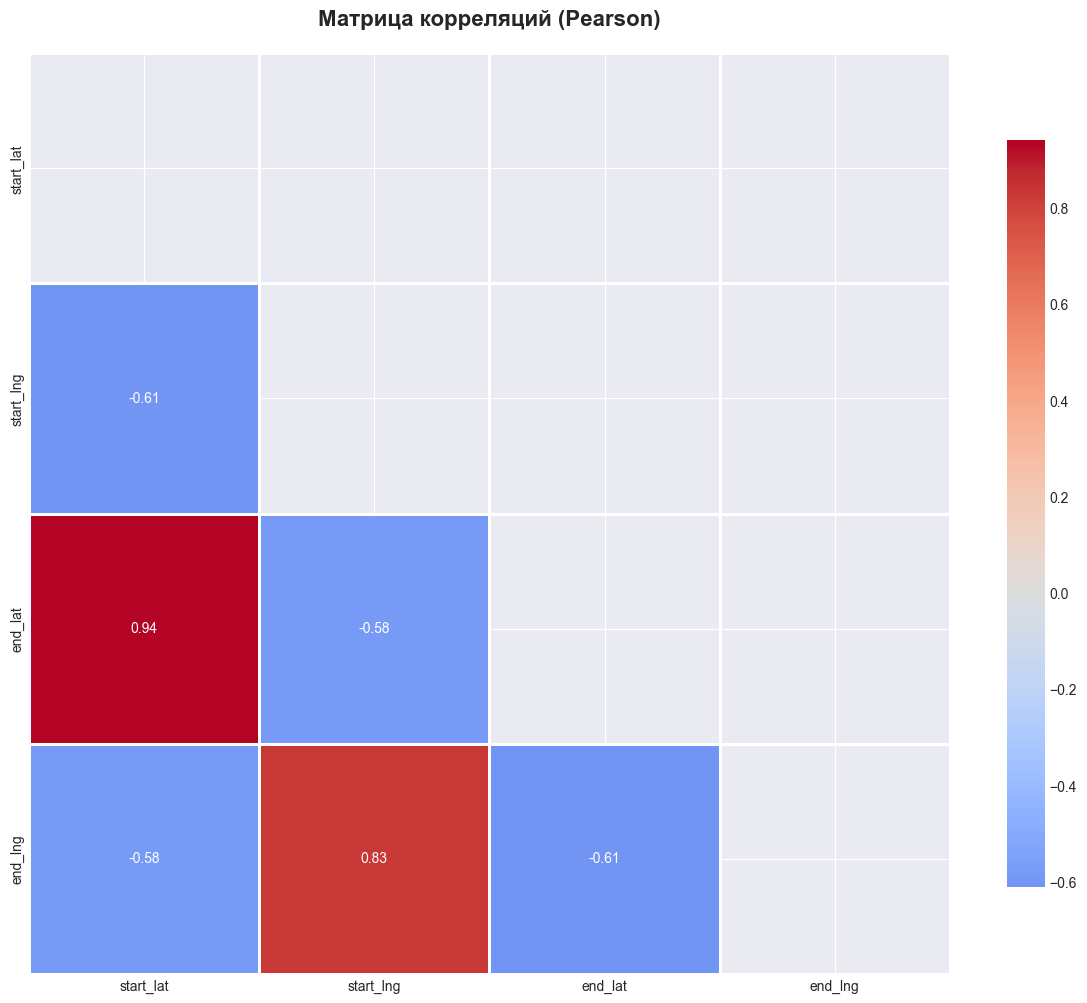

Построение pairplot для 4 колонок...


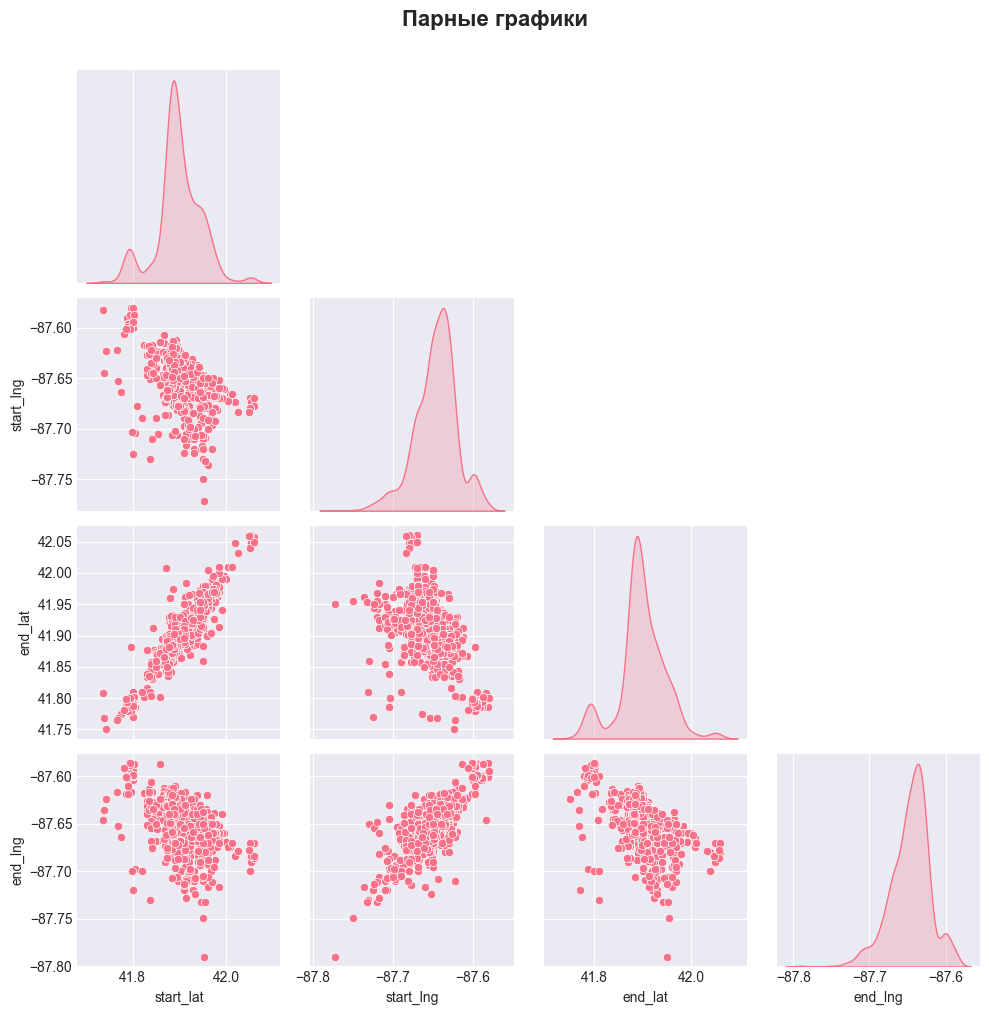

Колонки не найдены: ['a', 'b', 'c']
Доступные числовые колонки: ['start_lat', 'start_lng', 'end_lat', 'end_lng']


In [14]:
from src.visualization import plot_correlations, DataExplorer

plot_correlations(trips, method="pearson")

explorer = DataExplorer(trips)
explorer.plot_pairplot()               # авто-выбор до 5 колонок
explorer.plot_pairplot(cols=["a", "b", "c"], sample_size=2000)

Начинаем визуальное исследование данных...

1. Распределения числовых переменных


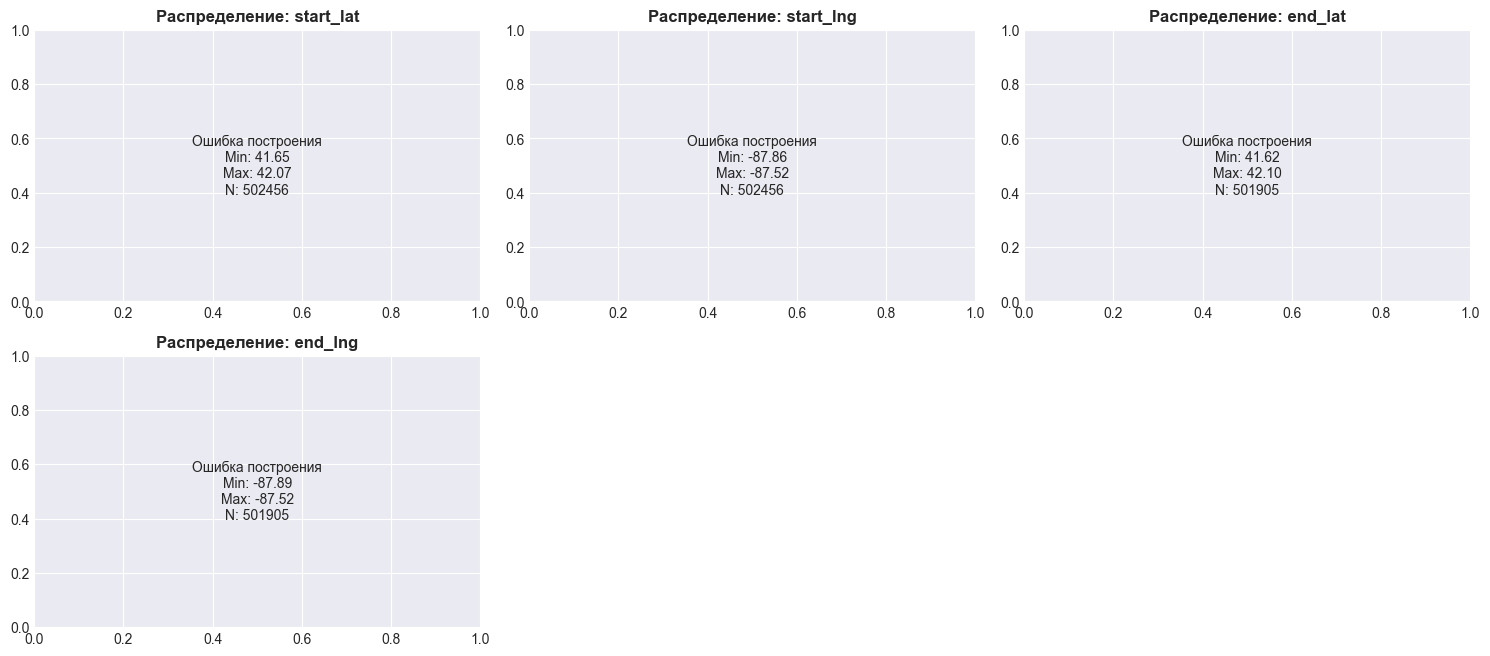


2. Boxplot'ы числовых переменных


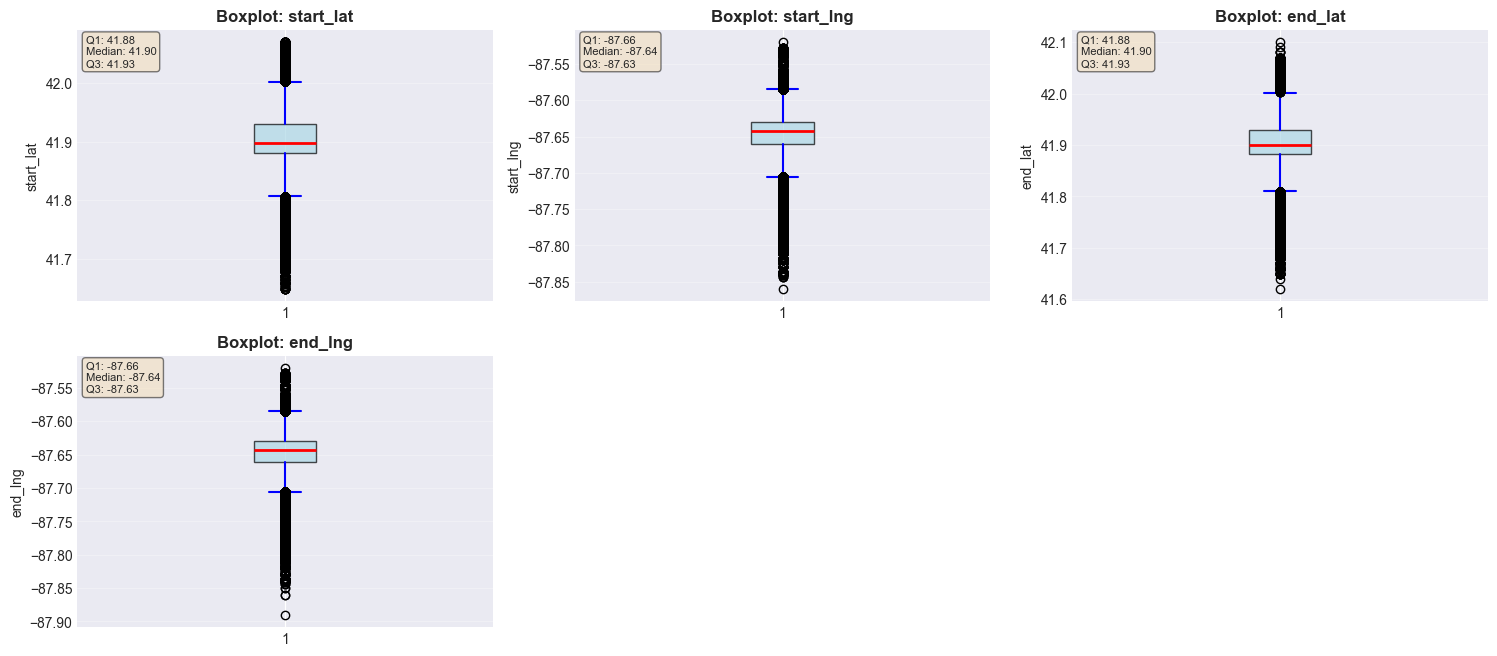


3. Матрица корреляций


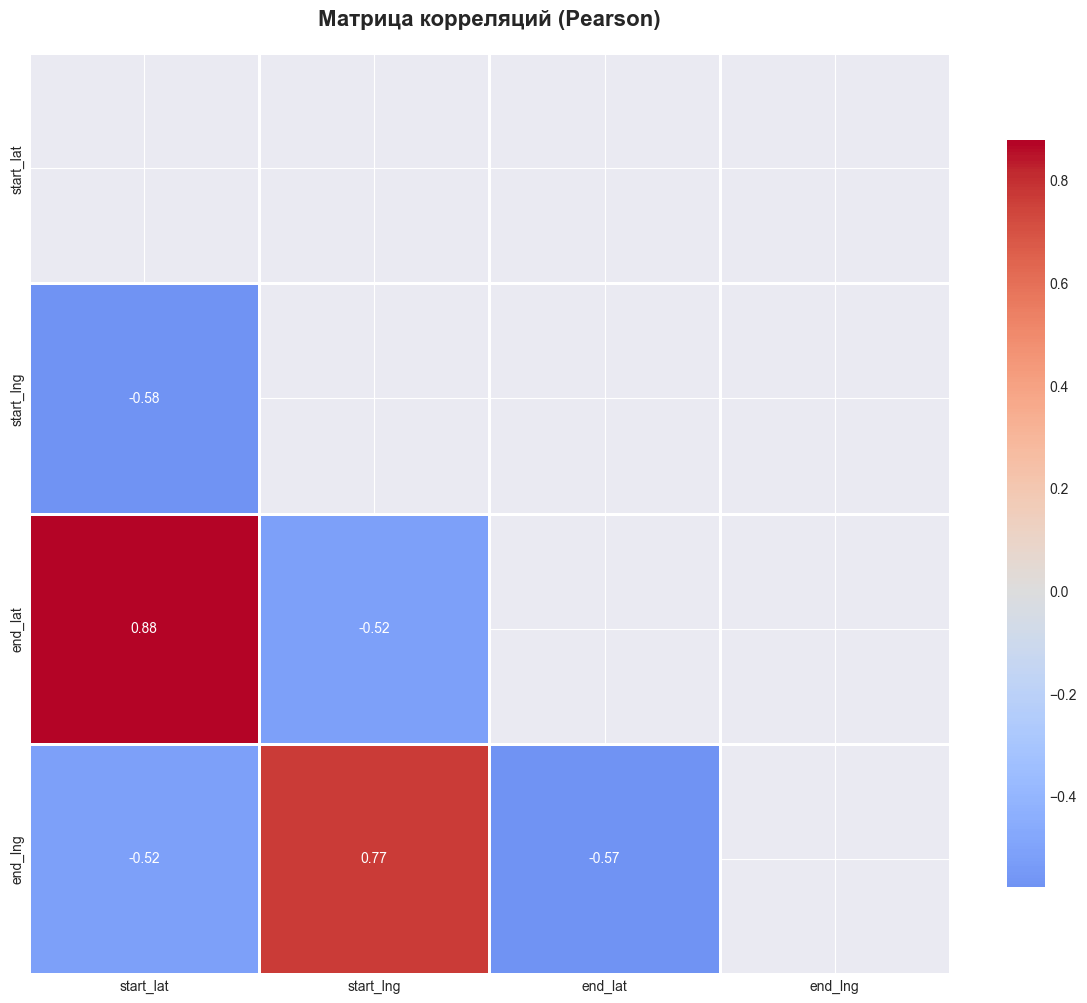


3.1. Парные графики для колонок: ['start_lat', 'start_lng', 'end_lat', 'end_lng']
Построение pairplot для 4 колонок...


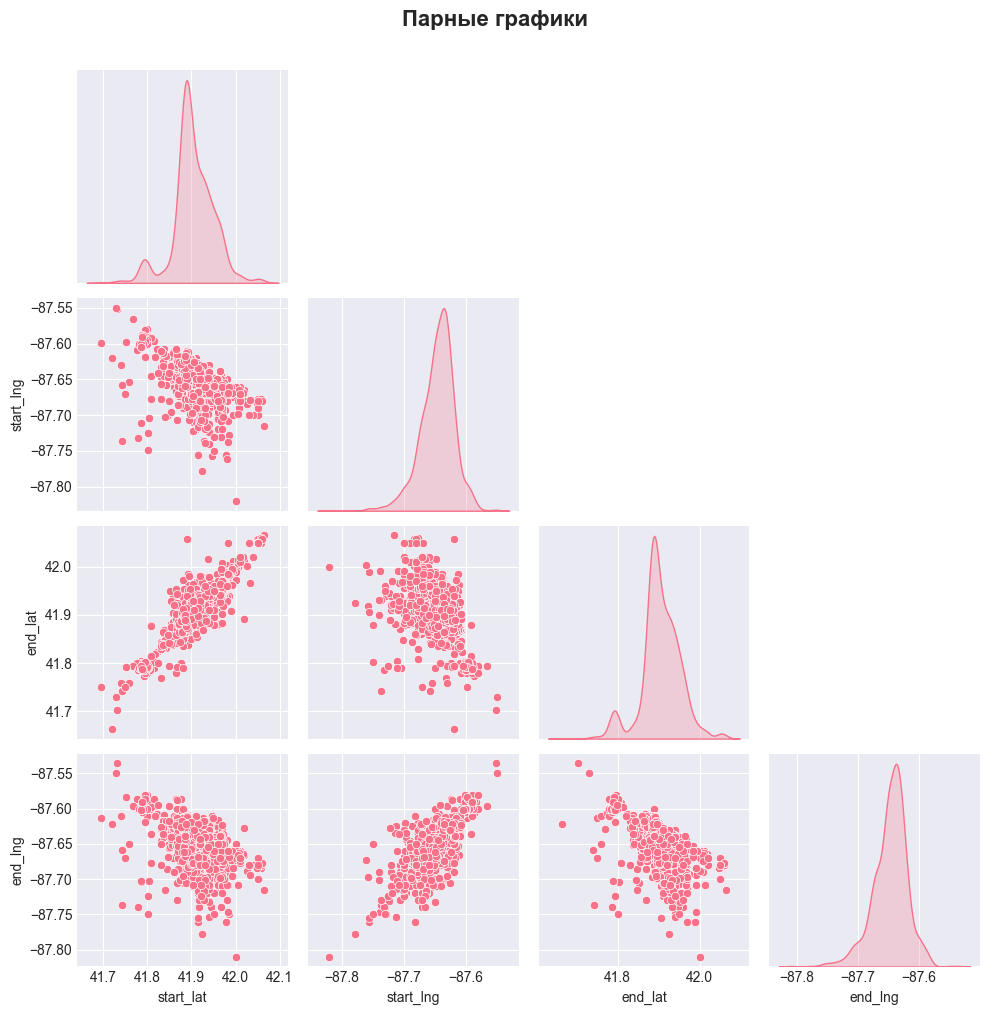


4. Категориальные переменные


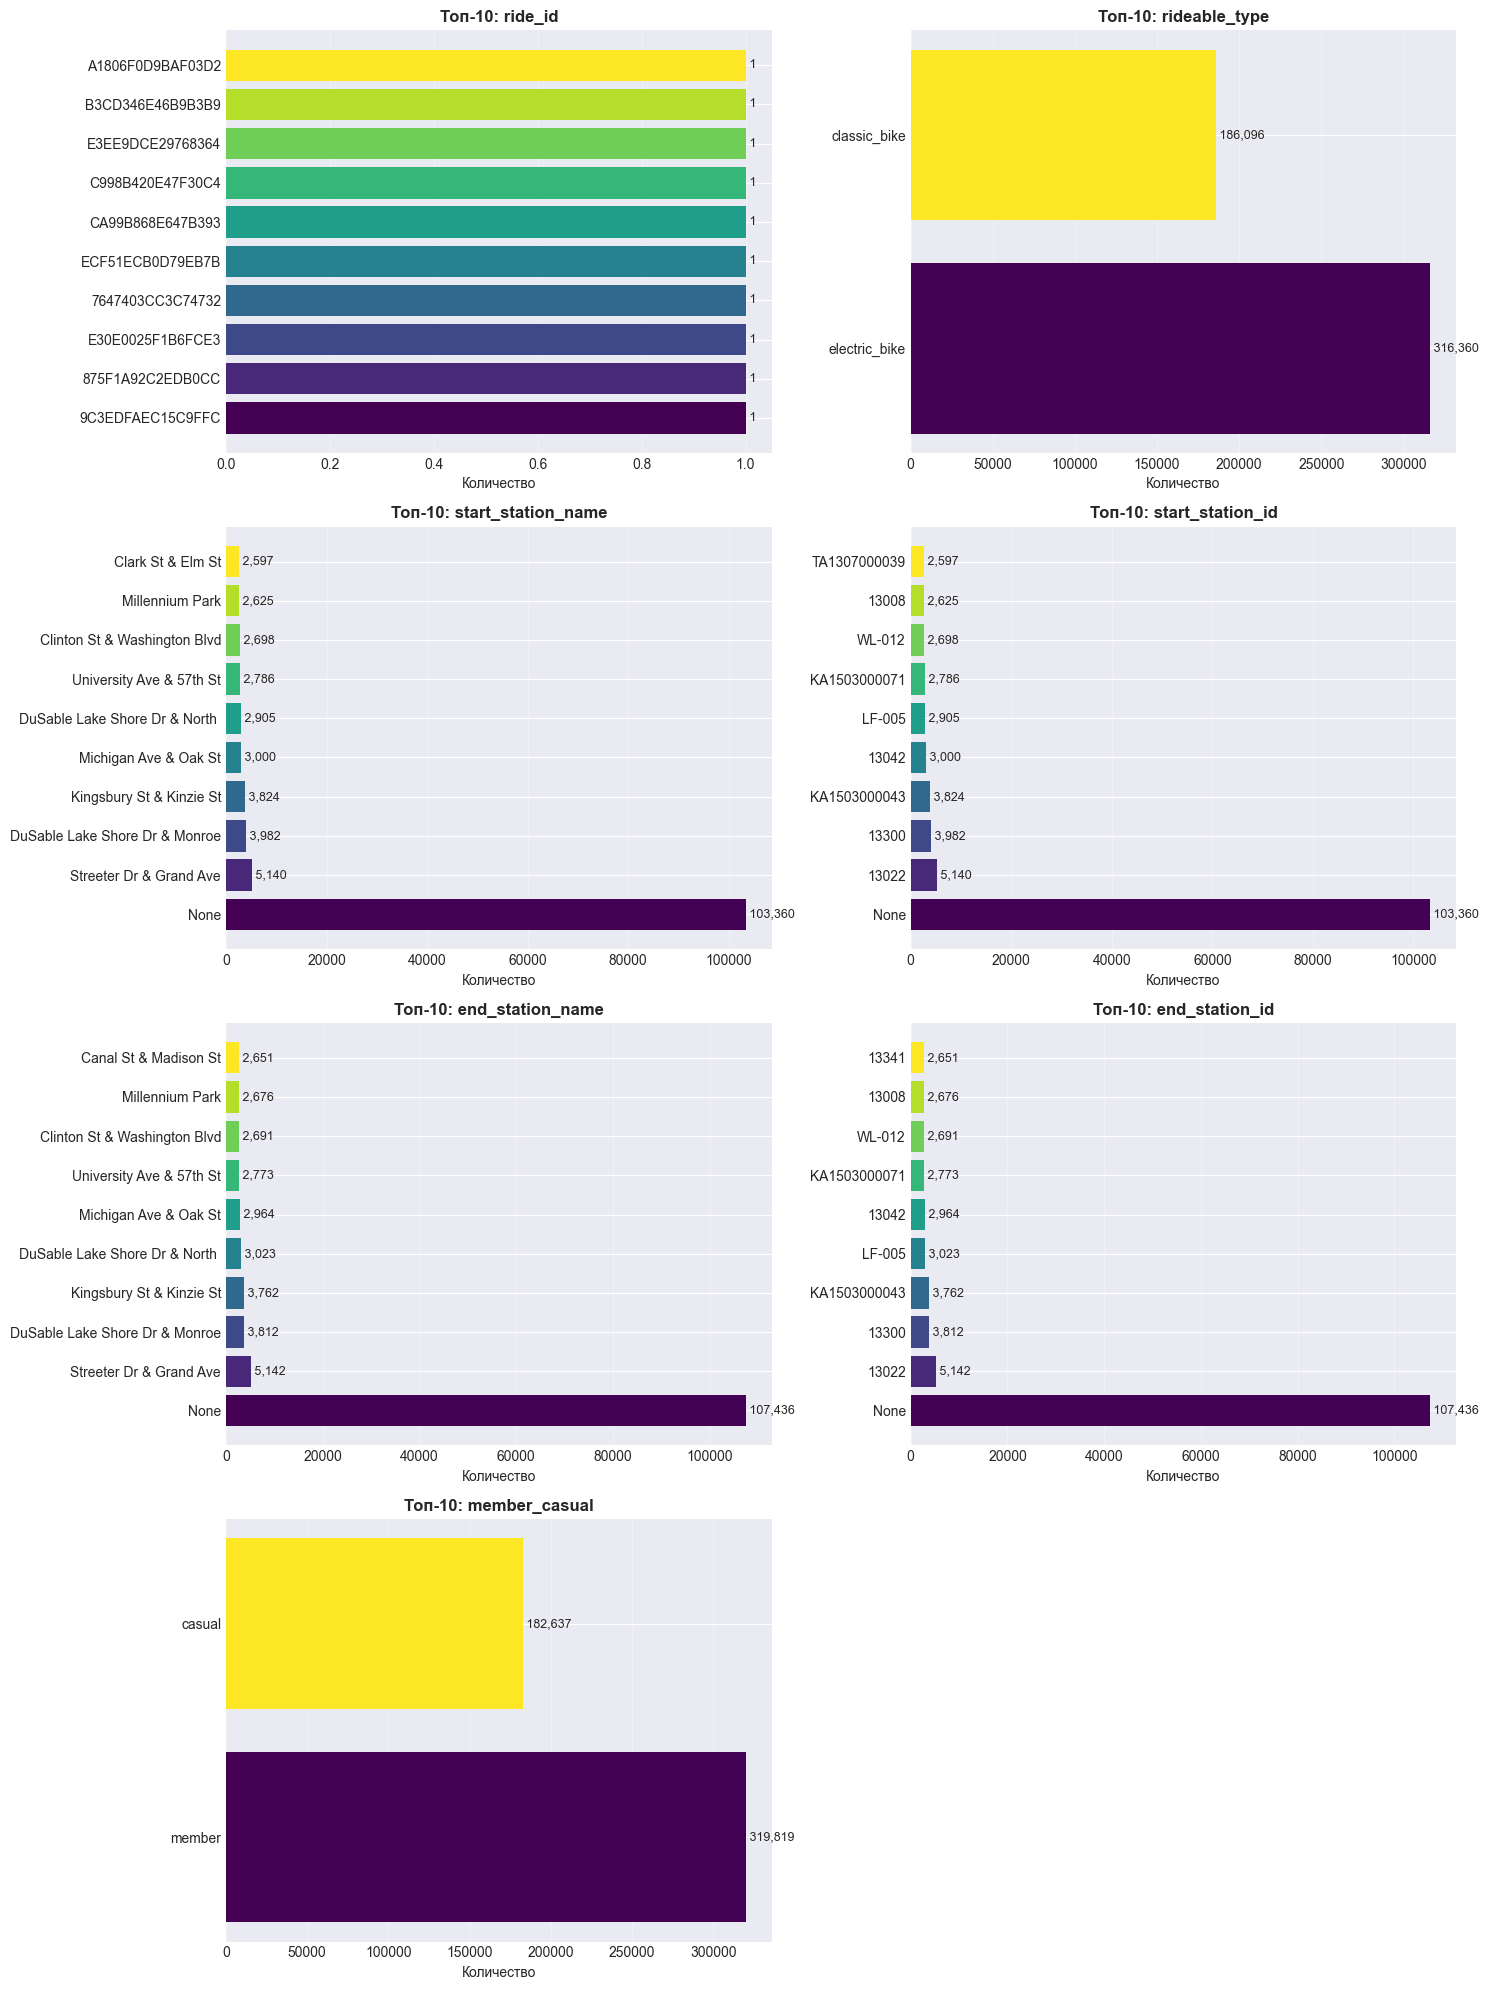


5. Карта пропусков


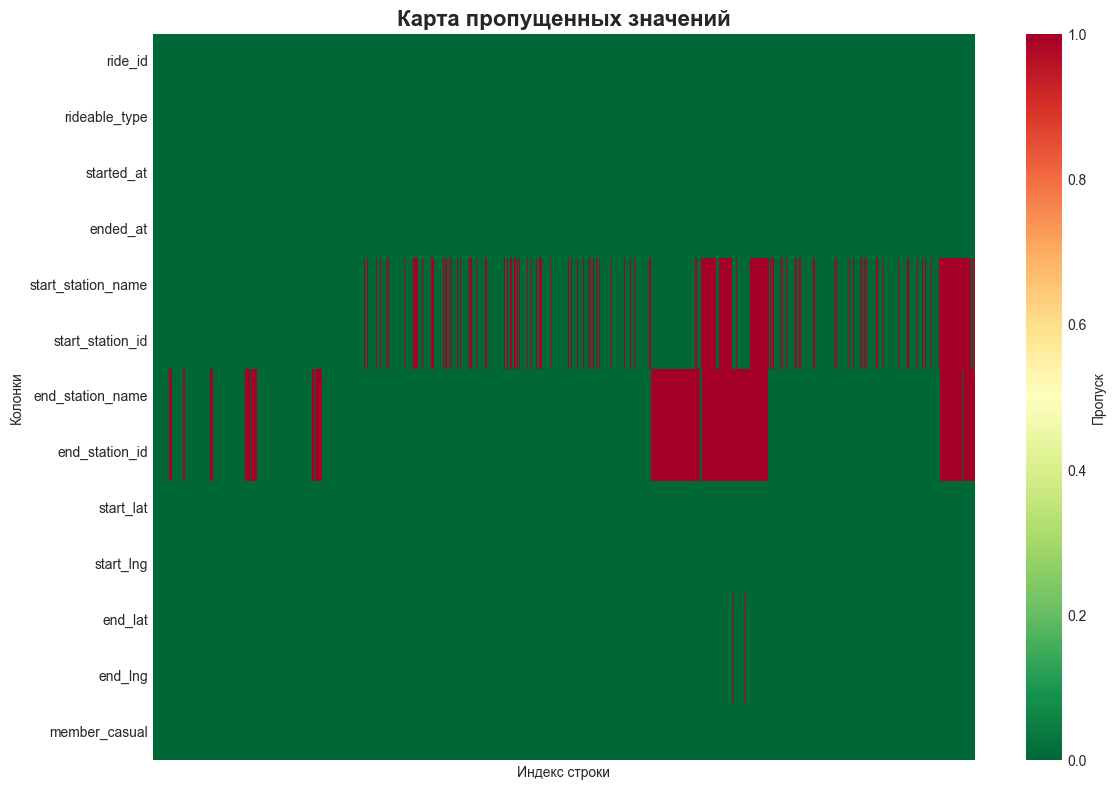


6. Временной ряд по started_at


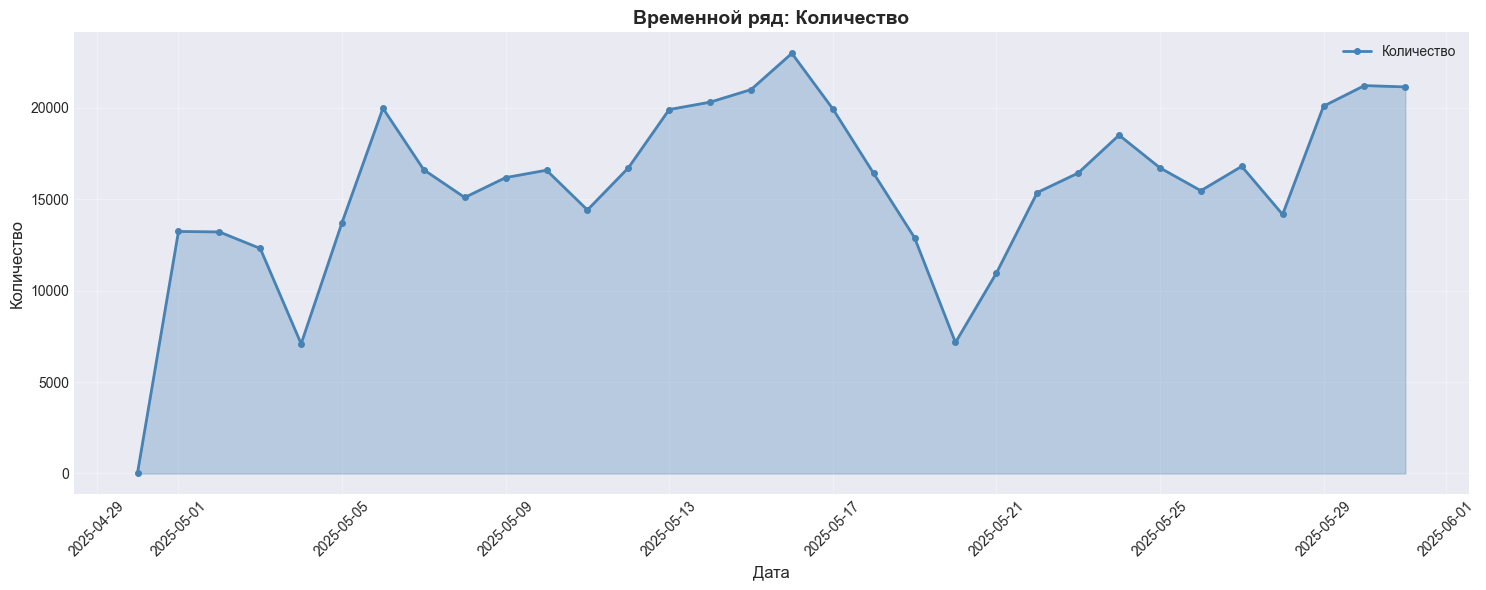


Визуальное исследование завершено!


In [15]:
import polars as pl
from src.data.load_data import load_raw_data
from src.visualization import explore_data

trips = load_raw_data(year=2025, month=5)
explore_data(trips)